# Hammerhead Shark Optimization Algorithm (HSOA) para TSP

Este notebook implementa el algoritmo HSOA adaptado al Problema del Viajante (TSP - Traveling Salesman Problem).

## Estructura del algoritmo:
1. **Inicialización**: Generar población de rutas aleatorias
2. **Búsqueda iterativa**: Exploración y explotación mediante operadores de movimiento
3. **Convergencia**: Movimiento hacia la mejor solución encontrada

## Importar librerías necesarias

In [178]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import random
import time

## Definición de la matriz de distancias y ciudades

In [179]:
def crear_matriz_distancias(num_ciudades: int, tipo: str = 'aleatoria') -> np.ndarray:
    """
    Crea una matriz de distancias entre ciudades.
    
    Args:
        num_ciudades: Número de ciudades
        tipo: 'aleatoria' para coordenadas aleatorias, 'simetrica' para matriz simétrica aleatoria
    
    Returns:
        Matriz de distancias (numpy array)
    """
    if tipo == 'aleatoria':
        # Generar coordenadas aleatorias para cada ciudad
        coordenadas = np.random.rand(num_ciudades, 2) * 100
        
        # Calcular matriz de distancias euclidiana
        matriz_distancias = np.zeros((num_ciudades, num_ciudades))
        for i in range(num_ciudades):
            for j in range(num_ciudades):
                if i != j:
                    dist = np.sqrt((coordenadas[i, 0] - coordenadas[j, 0])**2 + 
                                 (coordenadas[i, 1] - coordenadas[j, 1])**2)
                    matriz_distancias[i, j] = dist
        
        return matriz_distancias, coordenadas
    
    elif tipo == 'simetrica':
        # Generar matriz simétrica aleatoria
        matriz_distancias = np.random.rand(num_ciudades, num_ciudades) * 100
        matriz_distancias = (matriz_distancias + matriz_distancias.T) / 2
        np.fill_diagonal(matriz_distancias, 0)
        return matriz_distancias, None

# Ejemplo: Crear problema TSP con 20 ciudades
num_ciudades = 20
matriz_distancias, coordenadas = crear_matriz_distancias(num_ciudades, tipo='aleatoria')

print(f"Problema TSP con {num_ciudades} ciudades")
print(f"Forma de la matriz de distancias: {matriz_distancias.shape}")
print(f"\nPrimeras 5x5 distancias:\n{matriz_distancias[:5, :5]}")

Problema TSP con 20 ciudades
Forma de la matriz de distancias: (20, 20)

Primeras 5x5 distancias:
[[ 0.         50.17136011 82.42154906 32.75536921 33.19807081]
 [50.17136011  0.         72.64288903 72.50660878 17.05893848]
 [82.42154906 72.64288903  0.         71.69025114 70.91551038]
 [32.75536921 72.50660878 71.69025114  0.         56.55792068]
 [33.19807081 17.05893848 70.91551038 56.55792068  0.        ]]


## Matriz distancias & Hyperparámetros

In [180]:
NUM_CIUDADES = 50
MATRIZ_DISTANCIAS, COORDENADAS = crear_matriz_distancias(NUM_CIUDADES, tipo='aleatoria')

TAM_POBLACION = 30
PROB_EXPLOTACION = 0.3
NUM_SONARS = 5
MAX_ITERACIONES = 1000


## Funciones auxiliares para el TSP

In [181]:
def calcular_distancia_ruta(ruta: List[int], matriz_distancias: np.ndarray) -> float:
    # Calcula la distancia total de una ruta.
    distancia_total = 0.0
    for i in range(len(ruta) - 1):
        distancia_total += matriz_distancias[ruta[i], ruta[i + 1]]
    # Añadir distancia de regreso a la ciudad inicial
    distancia_total += matriz_distancias[ruta[-1], ruta[0]]
    return distancia_total


def generar_ruta_aleatoria(num_ciudades: int) -> List[int]:
    # Genera una ruta aleatoria (permutación de ciudades).
    ruta = list(range(num_ciudades))
    random.shuffle(ruta)
    return ruta


# Probar las funciones
ruta_ejemplo = generar_ruta_aleatoria(num_ciudades)
distancia_ejemplo = calcular_distancia_ruta(ruta_ejemplo, matriz_distancias)

print(f"Ruta ejemplo: {ruta_ejemplo[:10]}... (primeras 10 ciudades)")
print(f"Distancia total: {distancia_ejemplo:.2f}")

Ruta ejemplo: [19, 18, 0, 7, 15, 11, 5, 2, 9, 16]... (primeras 10 ciudades)
Distancia total: 1152.73


## Operadores de movimiento para exploración

In [182]:
def operador_swap(ruta: List[int]) -> List[int]:
    # Operador de intercambio (swap): intercambia dos ciudades aleatorias.
    nueva_ruta = ruta.copy()
    i, j = random.sample(range(len(ruta)), 2)
    nueva_ruta[i], nueva_ruta[j] = nueva_ruta[j], nueva_ruta[i]
    return nueva_ruta

def operador_inversion(ruta: List[int]) -> List[int]:
    # Operador de inversión: invierte un segmento aleatorio de la ruta.
    nueva_ruta = ruta.copy()
    i, j = sorted(random.sample(range(len(ruta)), 2))
    nueva_ruta[i:j+1] = reversed(nueva_ruta[i:j+1])
    return nueva_ruta

def operador_insercion(ruta: List[int]) -> List[int]:
    # Operador de inserción: extrae una ciudad y la inserta en otra posición.
    nueva_ruta = ruta.copy()
    i, j = random.sample(range(len(ruta)), 2)
    ciudad = nueva_ruta.pop(i)
    nueva_ruta.insert(j, ciudad)
    return nueva_ruta

def aplicar_operador_movimiento(ruta: List[int], tipo: str = 'aleatorio') -> List[int]:
    # Aplica un operador de movimiento a la ruta ('swap', 'inversion', 'insercion', 'aleatorio').
    if tipo == 'aleatorio':
        tipo = random.choice(['swap', 'inversion', 'insercion'])
    
    if tipo == 'swap':
        return operador_swap(ruta)
    elif tipo == 'inversion':
        return operador_inversion(ruta)
    elif tipo == 'insercion':
        return operador_insercion(ruta)
    else:
        raise ValueError(f"Tipo de operador desconocido: {tipo}")


# Probar operadores
print("Ruta original:", ruta_ejemplo[:10], "...")
print("Después de swap:", operador_swap(ruta_ejemplo)[:10], "...")
print("Después de inversión:", operador_inversion(ruta_ejemplo)[:10], "...")
print("Después de inserción:", operador_insercion(ruta_ejemplo)[:10], "...")

Ruta original: [19, 18, 0, 7, 15, 11, 5, 2, 9, 16] ...
Después de swap: [19, 18, 0, 15, 7, 11, 5, 2, 9, 16] ...
Después de inversión: [19, 18, 0, 7, 15, 11, 5, 2, 9, 16] ...
Después de inserción: [19, 18, 0, 7, 15, 11, 5, 2, 9, 16] ...


## Operador de combinación para explotación

In [183]:
def combinar_rutas_orden(ruta: List[int], mejor_ruta: List[int]) -> List[int]:
    # Combina una ruta con la mejor ruta preservando el orden manteniendo una permutación válida.
    n = len(ruta)
    # Determinar longitud del segmento a copiar
    longitud_segmento = random.randint(n // 4, n // 2)
    inicio = random.randint(0, n - longitud_segmento)
    
    # Copiar segmento de la mejor ruta
    segmento = mejor_ruta[inicio:inicio + longitud_segmento]
    
    # Crear nueva ruta: colocar el segmento en la misma posición
    nueva_ruta = [None] * n
    nueva_ruta[inicio:inicio + longitud_segmento] = segmento
    
    # Completar con las ciudades restantes de la ruta original en orden
    ciudades_usadas = set(segmento)
    idx = 0
    for i in range(n):
        if nueva_ruta[i] is None:
            # Buscar siguiente ciudad no usada de la ruta original
            while ruta[idx] in ciudades_usadas:
                idx += 1
            nueva_ruta[i] = ruta[idx]
            ciudades_usadas.add(ruta[idx])
            idx += 1
    
    return nueva_ruta


# Probar combinación
ruta_test = generar_ruta_aleatoria(10)
mejor_ruta_test = generar_ruta_aleatoria(10)

print("Ruta original:", ruta_test)
print("Mejor ruta:", mejor_ruta_test)
print("Combinación por orden:", combinar_rutas_orden(ruta_test, mejor_ruta_test))

Ruta original: [8, 1, 9, 7, 4, 3, 2, 0, 6, 5]
Mejor ruta: [5, 0, 4, 8, 1, 3, 2, 6, 7, 9]
Combinación por orden: [5, 0, 4, 8, 1, 9, 7, 3, 2, 6]


## Implementación del algoritmo HSOA para TSP

In [184]:
class HSOA_TSP:
    
    def __init__(self, 
                 matriz_distancias: np.ndarray = MATRIZ_DISTANCIAS,
                 tam_poblacion: int = TAM_POBLACION,
                 max_iteraciones: int = MAX_ITERACIONES,
                 num_sonars: int = NUM_SONARS,
                 prob_explotacion: float = PROB_EXPLOTACION,
                 verbose: bool = True):
        """
        Inicializa el algoritmo HSOA para TSP.
        
        Args:
            matriz_distancias: Matriz de distancias entre ciudades
            tam_poblacion: Número de rutas en la población
            max_iteraciones: Número máximo de iteraciones
            num_sonars: Número de vecinos a evaluar en la fase de exploración (visión amplia del martillo)
            prob_explotacion: Probabilidad de combinar con mejor ruta
            verbose: Si True, imprime información durante la ejecución
        """
        self.matriz_distancias = matriz_distancias
        self.num_ciudades = len(matriz_distancias)
        self.tam_poblacion = tam_poblacion
        self.max_iteraciones = max_iteraciones
        self.num_sonars = num_sonars
        self.prob_explotacion = prob_explotacion
        self.verbose = verbose
        
        # Población de rutas
        self.poblacion = []
        self.distancias = []
        
        # Mejor solución encontrada
        self.mejor_ruta = None
        self.mejor_distancia = float('inf')
        
        # Historial de convergencia
        self.historial_mejor = []
        self.historial_promedio = []
        self.historial_tiempos = []  # Tiempo acumulado por iteración
    
    def inicializar_poblacion(self):
        """
        Paso 1: Inicialización - Genera población inicial de rutas aleatorias.
        """
        if self.verbose:
            print("=" * 60)
            print("PASO 1: INICIALIZACIÓN")
            print("=" * 60)
        
        self.poblacion = []
        self.distancias = []
        
        for k in range(self.tam_poblacion):
            # Generar ruta aleatoria
            ruta = generar_ruta_aleatoria(self.num_ciudades)
            distancia = calcular_distancia_ruta(ruta, self.matriz_distancias)
            
            self.poblacion.append(ruta)
            self.distancias.append(distancia)
            
            # Actualizar mejor ruta
            if distancia < self.mejor_distancia:
                self.mejor_distancia = distancia
                self.mejor_ruta = ruta.copy()
        
        if self.verbose:
            print(f"Población inicial: {self.tam_poblacion} rutas")
            print(f"Mejor distancia inicial: {self.mejor_distancia:.2f}")
            print(f"Distancia promedio: {np.mean(self.distancias):.2f}")
            print(f"Distancia peor: {max(self.distancias):.2f}")
    
    def busqueda_iterativa(self, tiempo_inicio):
        """
        Paso 2: Búsqueda iterativa - Exploración (Rastreo Amplio) y Explotación (Caza).
        """
        if self.verbose:
            print("\n" + "=" * 60)
            print("PASO 2: BÚSQUEDA ITERATIVA")
            print("=" * 60)
        
        for iteracion in range(self.max_iteraciones):
            # Fase de Rastreo Amplio (Exploración): evaluar k vecinos y moverse al mejor
            for i in range(self.tam_poblacion):
                ruta_actual = self.poblacion[i]
                distancia_actual = self.distancias[i]
                
                # Generar k vecinos y evaluar cada uno
                mejor_vecino_ruta = ruta_actual
                mejor_vecino_distancia = distancia_actual
                
                for _ in range(self.num_sonars):
                    # Generar vecino con operador de movimiento aleatorio
                    vecino_ruta = aplicar_operador_movimiento(ruta_actual, tipo='aleatorio')
                    vecino_distancia = calcular_distancia_ruta(vecino_ruta, self.matriz_distancias)
                    
                    # Actualizar mejor vecino del grupo de k
                    if vecino_distancia < mejor_vecino_distancia:
                        mejor_vecino_ruta = vecino_ruta
                        mejor_vecino_distancia = vecino_distancia
                
                # Moverse al mejor vecino solo si es una mejora
                if mejor_vecino_distancia < distancia_actual:
                    self.poblacion[i] = mejor_vecino_ruta
                    self.distancias[i] = mejor_vecino_distancia
            
            # Actualizar mejor ruta global
            idx_mejor = np.argmin(self.distancias)
            if self.distancias[idx_mejor] < self.mejor_distancia:
                self.mejor_distancia = self.distancias[idx_mejor]
                self.mejor_ruta = self.poblacion[idx_mejor].copy()
            
            # Fase de Caza (Hunting): combinar con mejor ruta
            for i in range(self.tam_poblacion):
                if random.random() < self.prob_explotacion:
                    # Combinar con la mejor ruta
                    ruta_combinada = combinar_rutas_orden(
                        self.poblacion[i], 
                        self.mejor_ruta
                    )
                    distancia_combinada = calcular_distancia_ruta(
                        ruta_combinada, 
                        self.matriz_distancias
                    )
                    
                    # Aceptar si es mejor
                    if distancia_combinada < self.distancias[i]:
                        self.poblacion[i] = ruta_combinada
                        self.distancias[i] = distancia_combinada
            
            # Guardar historial
            self.historial_mejor.append(self.mejor_distancia)
            self.historial_promedio.append(np.mean(self.distancias))
            self.historial_tiempos.append(time.time() - tiempo_inicio)  # Tiempo acumulado
            
            # Mostrar progreso
            if self.verbose and (iteracion % 100 == 0 or iteracion == self.max_iteraciones - 1):
                print(f"Iteración {iteracion:4d} | "
                      f"Mejor: {self.mejor_distancia:8.2f} | "
                      f"Promedio: {np.mean(self.distancias):8.2f} | "
                      f"Peor: {max(self.distancias):8.2f}")
    
    def optimizar(self) -> Tuple[List[int], float]:
        """
        Ejecuta el algoritmo HSOA completo.
        
        Returns:
            Tupla con (mejor_ruta, mejor_distancia)
        """
        tiempo_inicio = time.time()
        
        # Paso 1: Inicialización
        self.inicializar_poblacion()
        
        # Paso 2: Búsqueda iterativa
        self.busqueda_iterativa(tiempo_inicio)
        
        tiempo_total = time.time() - tiempo_inicio
        
        # Paso 3: Resultado
        if self.verbose:
            print("\n" + "=" * 60)
            print("PASO 3: RESULTADO FINAL")
            print("=" * 60)
            print(f"Mejor ruta encontrada: {self.mejor_ruta}")
            print(f"Distancia total: {self.mejor_distancia:.2f}")
            print(f"Tiempo de ejecución: {tiempo_total:.2f} segundos")
        
        return self.mejor_ruta, self.mejor_distancia
    
    def plot_convergencia(self):
        """
        Grafica la convergencia del algoritmo.
        """
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.historial_mejor, label='Mejor distancia', linewidth=2)
        plt.plot(self.historial_promedio, label='Distancia promedio', alpha=0.7)
        plt.xlabel('Iteración')
        plt.ylabel('Distancia')
        plt.title('Convergencia del HSOA')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        mejora = ((self.historial_mejor[0] - np.array(self.historial_mejor)) / 
                  self.historial_mejor[0] * 100)
        plt.plot(mejora, color='green', linewidth=2)
        plt.xlabel('Iteración')
        plt.ylabel('Mejora (%)')
        plt.title('Porcentaje de mejora respecto a solución inicial')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


print("Clase HSOA_TSP definida correctamente ✓")


Clase HSOA_TSP definida correctamente ✓


## Función de visualización de la ruta

In [185]:
def visualizar_ruta(ruta: List[int], coordenadas: np.ndarray, distancia: float, titulo: str = "Ruta TSP"):
    """
    Visualiza una ruta del TSP en un gráfico 2D.
    
    Args:
        ruta: Lista de índices de ciudades en orden de visita
        coordenadas: Array con coordenadas (x, y) de cada ciudad
        distancia: Distancia total de la ruta
        titulo: Título del gráfico
    """
    if coordenadas is None:
        print("No hay coordenadas disponibles para visualizar.")
        return
    
    plt.figure(figsize=(10, 8))
    
    # Dibujar las ciudades
    plt.scatter(coordenadas[:, 0], coordenadas[:, 1], 
               c='red', s=200, zorder=3, alpha=0.7, edgecolors='black')
    
    # Etiquetar las ciudades
    for i, (x, y) in enumerate(coordenadas):
        plt.annotate(str(i), (x, y), fontsize=9, ha='center', va='center', color='white', weight='bold')
    
    # Dibujar la ruta
    for i in range(len(ruta)):
        ciudad_actual = ruta[i]
        ciudad_siguiente = ruta[(i + 1) % len(ruta)]
        
        x1, y1 = coordenadas[ciudad_actual]
        x2, y2 = coordenadas[ciudad_siguiente]
        
        plt.plot([x1, x2], [y1, y2], 'b-', linewidth=1.5, alpha=0.6, zorder=1)
        
        # Añadir flecha para mostrar dirección
        if i < len(ruta) - 1 or i == len(ruta) - 1:
            dx, dy = x2 - x1, y2 - y1
            plt.arrow(x1 + dx*0.3, y1 + dy*0.3, dx*0.15, dy*0.15,
                     head_width=2, head_length=1.5, fc='blue', ec='blue', alpha=0.5, zorder=2)
    
    plt.title(f'{titulo}\nDistancia total: {distancia:.2f}', fontsize=14, weight='bold')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


print("Función de visualización definida correctamente ✓")

Función de visualización definida correctamente ✓


## Ejecución Problema TSP

In [186]:
# Configuración de semilla para reproducibilidad
np.random.seed(42)
random.seed(42)

# Configurar y ejecutar HSOA
hsoa = HSOA_TSP(
    matriz_distancias=MATRIZ_DISTANCIAS,
    tam_poblacion=TAM_POBLACION,           # Tamaño de población
    max_iteraciones=MAX_ITERACIONES,        # Número de iteraciones
    num_sonars=NUM_SONARS,                    # Número de vecinos a evaluar (visión amplia del martillo)
    prob_explotacion=PROB_EXPLOTACION,       # Probabilidad de combinar con mejor ruta
    verbose=True
)

mejor_ruta, mejor_distancia = hsoa.optimizar()


PASO 1: INICIALIZACIÓN
Población inicial: 30 rutas
Mejor distancia inicial: 2438.51
Distancia promedio: 2730.48
Distancia peor: 3029.10

PASO 2: BÚSQUEDA ITERATIVA
Iteración    0 | Mejor:  2381.56 | Promedio:  2611.45 | Peor:  2962.46
Iteración  100 | Mejor:   948.42 | Promedio:  1095.03 | Peor:  1189.37
Iteración  200 | Mejor:   769.33 | Promedio:   847.25 | Peor:   950.15
Iteración  300 | Mejor:   705.47 | Promedio:   762.28 | Peor:   870.48
Iteración  400 | Mejor:   664.10 | Promedio:   709.38 | Peor:   806.03
Iteración  500 | Mejor:   630.02 | Promedio:   673.73 | Peor:   729.01
Iteración  600 | Mejor:   626.27 | Promedio:   650.15 | Peor:   698.01
Iteración  700 | Mejor:   616.96 | Promedio:   636.06 | Peor:   693.07
Iteración  800 | Mejor:   616.96 | Promedio:   630.93 | Peor:   678.86
Iteración  900 | Mejor:   616.96 | Promedio:   629.64 | Peor:   678.86
Iteración  999 | Mejor:   615.23 | Promedio:   625.76 | Peor:   671.03

PASO 3: RESULTADO FINAL
Mejor ruta encontrada: [42, 46

##### Visualización de resultados

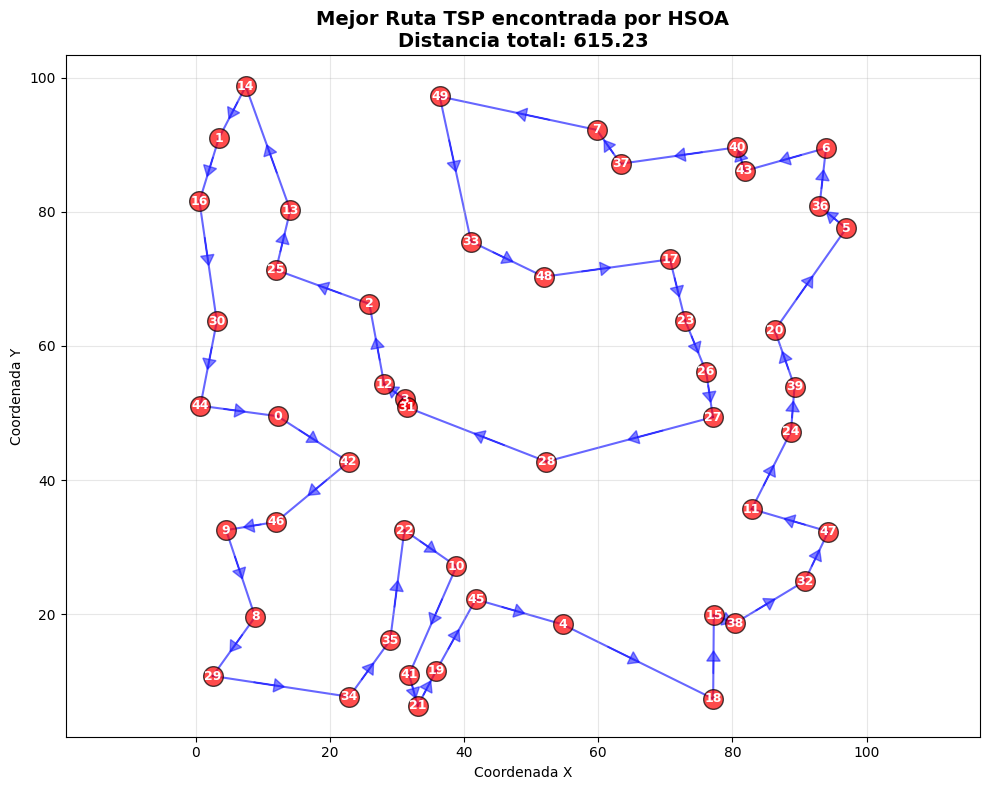

In [187]:
# Visualizar la mejor ruta encontrada
visualizar_ruta(mejor_ruta, COORDENADAS, mejor_distancia, 
                titulo="Mejor Ruta TSP encontrada por HSOA")

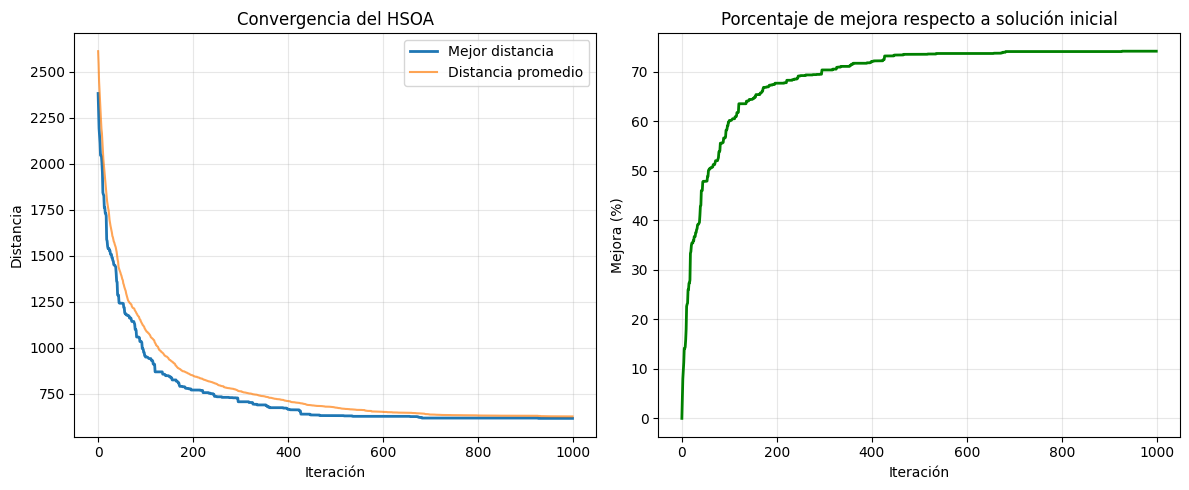

In [188]:
# Visualizar convergencia del algoritmo
hsoa.plot_convergencia()

## Análisis de Hiperparámetros

En esta sección analizaremos el impacto de diferentes hiperparámetros en el rendimiento del algoritmo HSOA:
- **sniffer_count**: Tamaño de la población
- **max_iteraciones**: Número de iteraciones del algoritmo
- **num_sonars**: Número de vecinos a evaluar en la fase de exploración (visión amplia del martillo)
- **prob_explotacion**: Probabilidad de combinar con la mejor ruta (explotación)


### 1. Análisis de `sniffer_count` (Tamaño de población)

In [189]:
# Probar diferentes tamaños de población
tam_poblacions = [1, 2, 5, 10, 25, 50, 100]
resultados_sniffer = []

print("Analizando impacto de tam_poblacion...")
print("=" * 70)

for sc in tam_poblacions:
    print(f"\nProbando tam_poblacion = {sc}")

    # Crear nueva instancia de HSOA
    hsoa_test = HSOA_TSP(
        matriz_distancias=MATRIZ_DISTANCIAS,
        tam_poblacion=sc,
        max_iteraciones=MAX_ITERACIONES,
        num_sonars=NUM_SONARS,
        prob_explotacion=PROB_EXPLOTACION,
        verbose=False
    )

    # Ejecutar optimización
    mejor_ruta_test, mejor_dist_test = hsoa_test.optimizar()

    resultados_sniffer.append({
        'tam_poblacion': sc,
        'mejor_distancia': mejor_dist_test,
        'historial': hsoa_test.historial_mejor.copy(),
        'distancia_final': hsoa_test.historial_mejor[-1],
        'mejora': (hsoa_test.historial_mejor[0] - hsoa_test.historial_mejor[-1]) / hsoa_test.historial_mejor[0] * 100
    })

    print(f"  → Distancia final: {mejor_dist_test:.2f}")
    print(f"  → Mejora: {resultados_sniffer[-1]['mejora']:.2f}%")

print("\n" + "=" * 70)
print("Análisis completado ✓")


Analizando impacto de tam_poblacion...

Probando tam_poblacion = 1
  → Distancia final: 648.25
  → Mejora: 75.45%

Probando tam_poblacion = 2
  → Distancia final: 597.48
  → Mejora: 75.98%

Probando tam_poblacion = 5
  → Distancia final: 627.02
  → Mejora: 75.34%

Probando tam_poblacion = 10
  → Distancia final: 630.63
  → Mejora: 74.25%

Probando tam_poblacion = 25
  → Distancia final: 602.18
  → Mejora: 71.89%

Probando tam_poblacion = 50
  → Distancia final: 612.19
  → Mejora: 74.15%

Probando tam_poblacion = 100
  → Distancia final: 598.57
  → Mejora: 74.28%

Análisis completado ✓


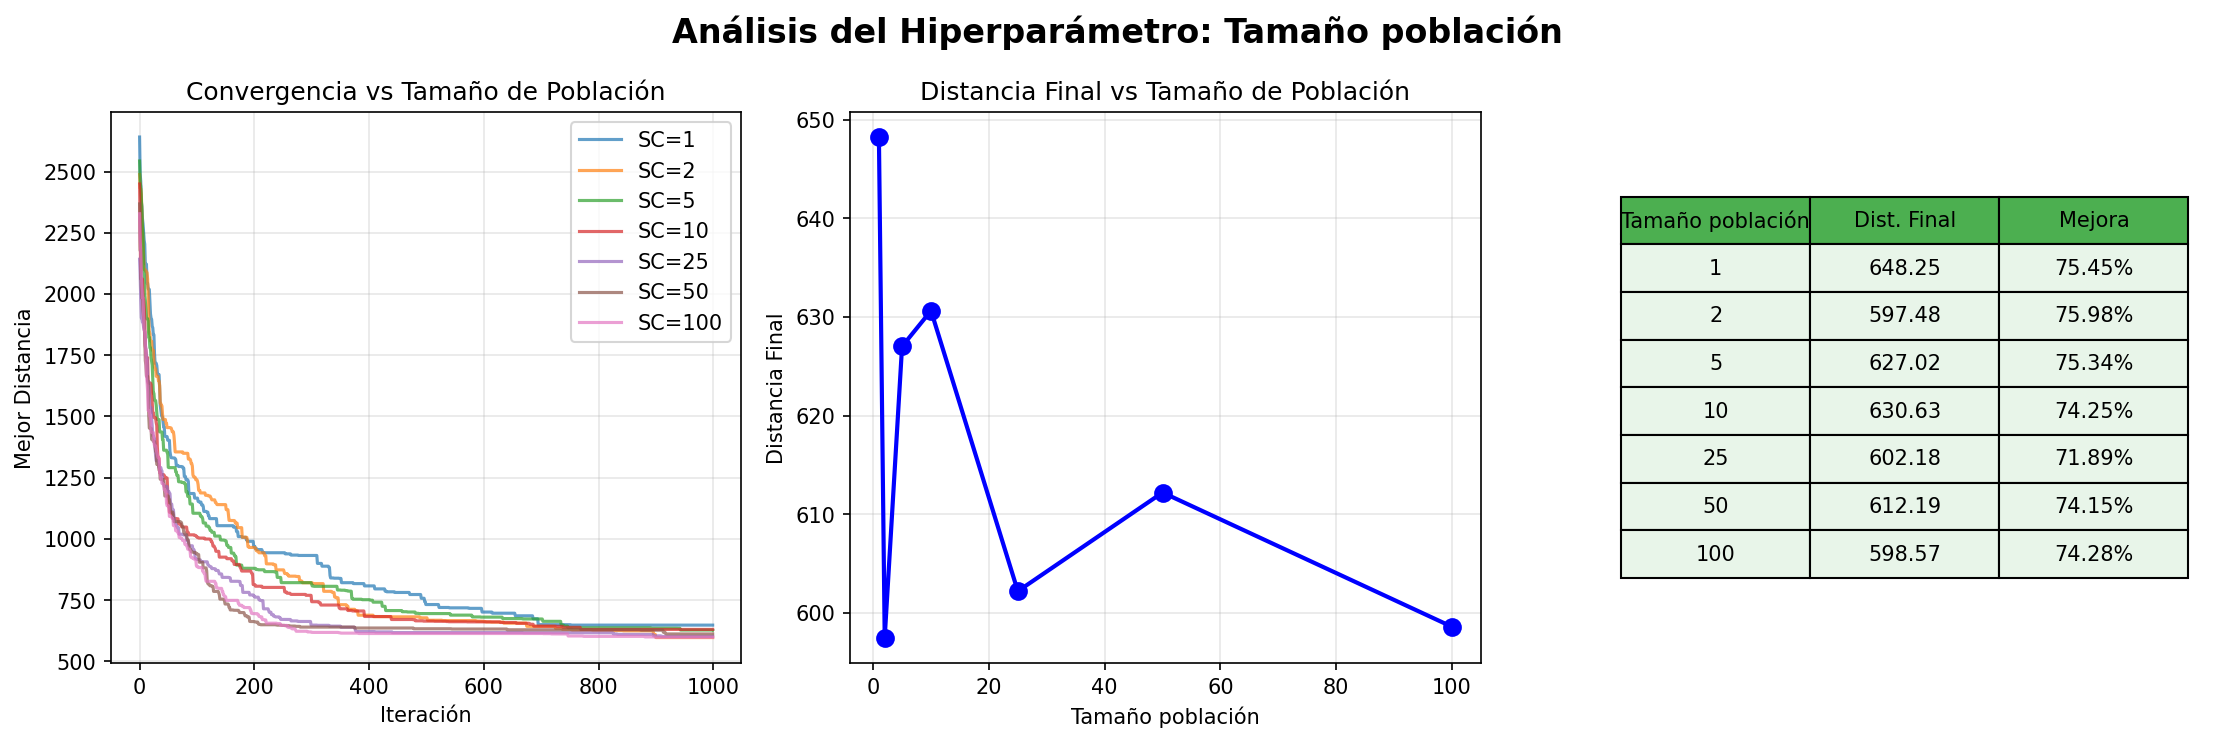

In [204]:
# Visualizar resultados de tam_poblacion
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=150)

# Gráfica 1: Convergencia para cada tam_poblacion
ax1 = axes[0]
for res in resultados_sniffer:
    ax1.plot(res['historial'], label=f"SC={res['tam_poblacion']}", alpha=0.7)
ax1.set_xlabel('Iteración')
ax1.set_ylabel('Mejor Distancia')
ax1.set_title('Convergencia vs Tamaño de Población')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfica 2: Distancia final vs tam_poblacion
ax2 = axes[1]
sc_values = [r['tam_poblacion'] for r in resultados_sniffer]
dist_finales = [r['distancia_final'] for r in resultados_sniffer]
ax2.plot(sc_values, dist_finales, 'o-', linewidth=2, markersize=8, color='blue')
ax2.set_xlabel('Tamaño población')
ax2.set_ylabel('Distancia Final')
ax2.set_title('Distancia Final vs Tamaño de Población')
ax2.grid(True, alpha=0.3)

# Gráfica 3: Tabla resumen
ax3 = axes[2]
ax3.axis('tight')
ax3.axis('off')
tabla_data = [[r['tam_poblacion'], f"{r['distancia_final']:.2f}", f"{r['mejora']:.2f}%"] 
              for r in resultados_sniffer]
tabla = ax3.table(cellText=tabla_data, 
                  colLabels=['Tamaño población', 'Dist. Final', 'Mejora'],
                  cellLoc='center', loc='center',
                  colWidths=[0.3, 0.3, 0.3])
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1, 2)
for i in range(len(sc_values) + 1):
    if i == 0:
        tabla[(i, 0)].set_facecolor('#4CAF50')
        tabla[(i, 1)].set_facecolor('#4CAF50')
        tabla[(i, 2)].set_facecolor('#4CAF50')
    else:
        tabla[(i, 0)].set_facecolor('#E8F5E9')
        tabla[(i, 1)].set_facecolor('#E8F5E9')
        tabla[(i, 2)].set_facecolor('#E8F5E9')

plt.suptitle('Análisis del Hiperparámetro: Tamaño población', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 2. Análisis de `num_sonars` (Visión amplia del martillo)


In [191]:
# Probar diferentes valores de num_sonars
num_sonars_values = [1, 3, 5, 7, 10, 15, 20, 25]
resultados_num_sonars = []

print("Analizando impacto de num_sonars...")
print("=" * 70)

for kv in num_sonars_values:
    print(f"\nProbando num_sonars = {kv}")
    
    hsoa_test = HSOA_TSP(
        matriz_distancias=MATRIZ_DISTANCIAS,
        tam_poblacion=TAM_POBLACION,
        max_iteraciones=MAX_ITERACIONES,
        num_sonars=kv,
        prob_explotacion=PROB_EXPLOTACION,
        verbose=False
    )
    
    mejor_ruta_test, mejor_dist_test = hsoa_test.optimizar()
    
    resultados_num_sonars.append({
        'num_sonars': kv,
        'mejor_distancia': mejor_dist_test,
        'historial': hsoa_test.historial_mejor.copy(),
        'distancia_final': hsoa_test.historial_mejor[-1],
        'mejora': (hsoa_test.historial_mejor[0] - hsoa_test.historial_mejor[-1]) / hsoa_test.historial_mejor[0] * 100
    })
    
    print(f"  → Distancia final: {mejor_dist_test:.2f}")
    print(f"  → Mejora: {resultados_num_sonars[-1]['mejora']:.2f}%")

print("\n" + "=" * 70)
print("Análisis completado ✓")


Analizando impacto de num_sonars...

Probando num_sonars = 1
  → Distancia final: 632.68
  → Mejora: 73.30%

Probando num_sonars = 3
  → Distancia final: 637.87
  → Mejora: 72.30%

Probando num_sonars = 5
  → Distancia final: 602.00
  → Mejora: 74.37%

Probando num_sonars = 7
  → Distancia final: 604.93
  → Mejora: 71.73%

Probando num_sonars = 10
  → Distancia final: 599.31
  → Mejora: 73.50%

Probando num_sonars = 15
  → Distancia final: 593.90
  → Mejora: 74.38%

Probando num_sonars = 20
  → Distancia final: 596.18
  → Mejora: 73.11%

Probando num_sonars = 25
  → Distancia final: 598.15
  → Mejora: 74.04%

Análisis completado ✓


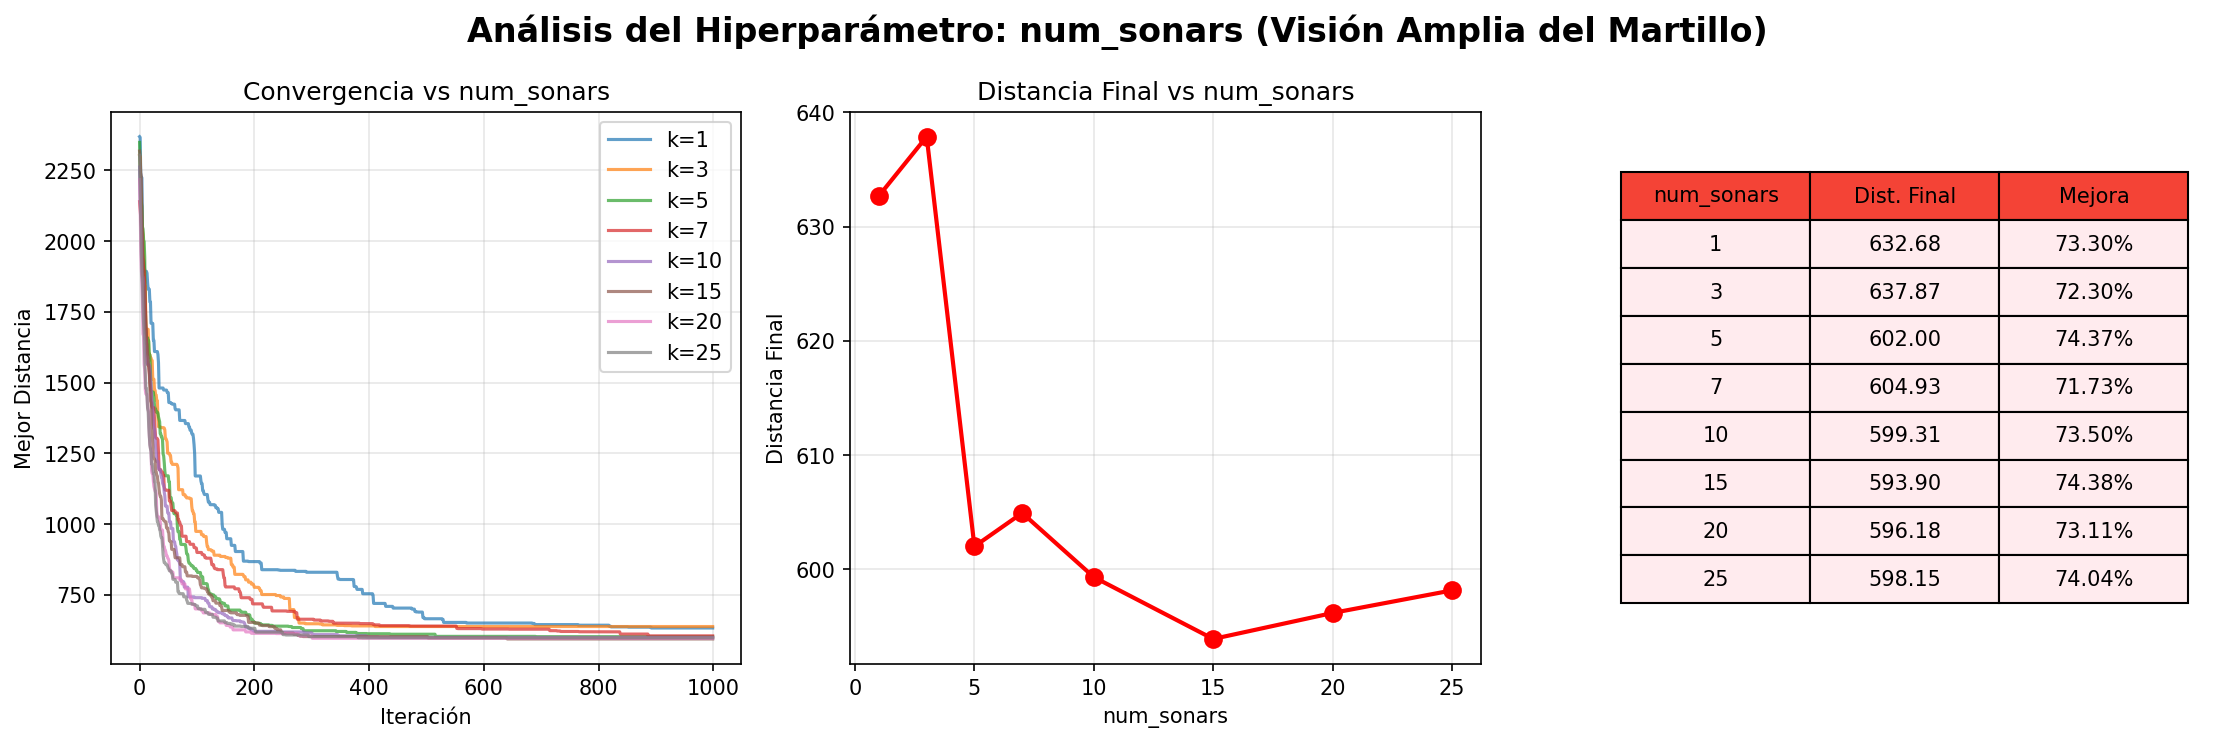

In [192]:
# Visualizar resultados de num_sonars
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=150)

# Gráfica 1: Convergencia para cada num_sonars
ax1 = axes[0]
for res in resultados_num_sonars:
    ax1.plot(res['historial'], label=f"k={res['num_sonars']}", alpha=0.7)
ax1.set_xlabel('Iteración')
ax1.set_ylabel('Mejor Distancia')
ax1.set_title('Convergencia vs num_sonars')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfica 2: Distancia final vs num_sonars
ax2 = axes[1]
kv_values = [r['num_sonars'] for r in resultados_num_sonars]
dist_finales = [r['distancia_final'] for r in resultados_num_sonars]
ax2.plot(kv_values, dist_finales, 'o-', linewidth=2, markersize=8, color='red')
ax2.set_xlabel('num_sonars')
ax2.set_ylabel('Distancia Final')
ax2.set_title('Distancia Final vs num_sonars')
ax2.grid(True, alpha=0.3)

# Gráfica 3: Tabla resumen
ax3 = axes[2]
ax3.axis('tight')
ax3.axis('off')
tabla_data = [[f"{r['num_sonars']}", f"{r['distancia_final']:.2f}", f"{r['mejora']:.2f}%"] 
              for r in resultados_num_sonars]
tabla = ax3.table(cellText=tabla_data, 
                  colLabels=['num_sonars', 'Dist. Final', 'Mejora'],
                  cellLoc='center', loc='center',
                  colWidths=[0.3, 0.3, 0.3])
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1, 2)
for i in range(len(kv_values) + 1):
    if i == 0:
        tabla[(i, 0)].set_facecolor('#F44336')
        tabla[(i, 1)].set_facecolor('#F44336')
        tabla[(i, 2)].set_facecolor('#F44336')
    else:
        tabla[(i, 0)].set_facecolor('#FFEBEE')
        tabla[(i, 1)].set_facecolor('#FFEBEE')
        tabla[(i, 2)].set_facecolor('#FFEBEE')

plt.suptitle('Análisis del Hiperparámetro: num_sonars (Visión Amplia del Martillo)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


### 3. Análisis de `prob_explotacion` (Probabilidad de explotación)

In [193]:
# Probar diferentes probabilidades de explotación
prob_explot = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
resultados_explot = []

print("Analizando impacto de prob_explotacion...")
print("=" * 70)

for px in prob_explot:
    print(f"\nProbando prob_explotacion = {px}")
    
    hsoa_test = HSOA_TSP(
        matriz_distancias=MATRIZ_DISTANCIAS,
        tam_poblacion=TAM_POBLACION,
        max_iteraciones=MAX_ITERACIONES,
        num_sonars=NUM_SONARS,
        prob_explotacion=px,
        verbose=False
    )
    
    mejor_ruta_test, mejor_dist_test = hsoa_test.optimizar()
    
    resultados_explot.append({
        'prob_explotacion': px,
        'mejor_distancia': mejor_dist_test,
        'historial': hsoa_test.historial_mejor.copy(),
        'distancia_final': hsoa_test.historial_mejor[-1],
        'mejora': (hsoa_test.historial_mejor[0] - hsoa_test.historial_mejor[-1]) / hsoa_test.historial_mejor[0] * 100
    })
    
    print(f"  → Distancia final: {mejor_dist_test:.2f}")
    print(f"  → Mejora: {resultados_explot[-1]['mejora']:.2f}%")

print("\n" + "=" * 70)
print("Análisis completado ✓")


Analizando impacto de prob_explotacion...

Probando prob_explotacion = 0.0
  → Distancia final: 627.86
  → Mejora: 73.47%

Probando prob_explotacion = 0.1
  → Distancia final: 607.31
  → Mejora: 70.06%

Probando prob_explotacion = 0.2
  → Distancia final: 592.74
  → Mejora: 75.39%

Probando prob_explotacion = 0.3
  → Distancia final: 607.43
  → Mejora: 72.93%

Probando prob_explotacion = 0.4
  → Distancia final: 609.12
  → Mejora: 73.45%

Probando prob_explotacion = 0.5
  → Distancia final: 614.61
  → Mejora: 72.57%

Probando prob_explotacion = 0.6
  → Distancia final: 610.96
  → Mejora: 73.62%

Probando prob_explotacion = 0.7
  → Distancia final: 606.09
  → Mejora: 74.25%

Probando prob_explotacion = 0.8
  → Distancia final: 626.16
  → Mejora: 74.42%

Probando prob_explotacion = 1.0
  → Distancia final: 615.00
  → Mejora: 74.17%

Análisis completado ✓


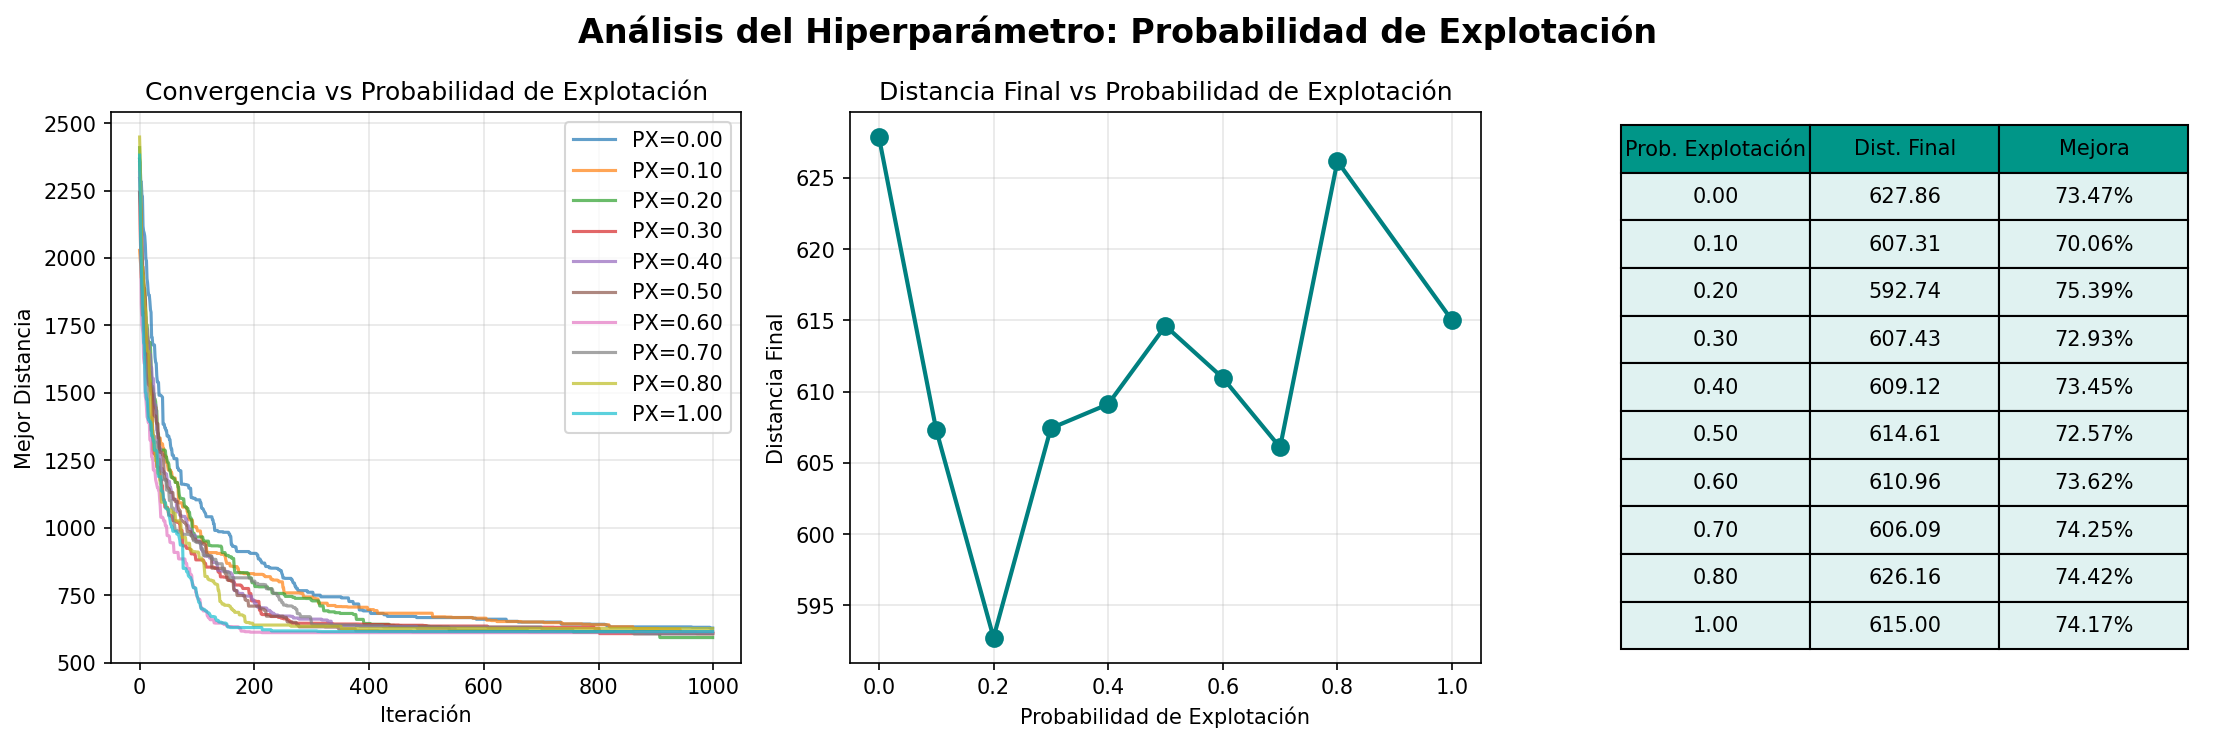

In [194]:
# Visualizar resultados de prob_explotacion
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=150)

# Gráfica 1: Convergencia para cada prob_explotacion
ax1 = axes[0]
for res in resultados_explot:
    ax1.plot(res['historial'], label=f"PX={res['prob_explotacion']:.2f}", alpha=0.7)
ax1.set_xlabel('Iteración')
ax1.set_ylabel('Mejor Distancia')
ax1.set_title('Convergencia vs Probabilidad de Explotación')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfica 2: Distancia final vs prob_explotacion
ax2 = axes[1]
px_values = [r['prob_explotacion'] for r in resultados_explot]
dist_finales = [r['distancia_final'] for r in resultados_explot]
ax2.plot(px_values, dist_finales, 'o-', linewidth=2, markersize=8, color='teal')
ax2.set_xlabel('Probabilidad de Explotación')
ax2.set_ylabel('Distancia Final')
ax2.set_title('Distancia Final vs Probabilidad de Explotación')
ax2.grid(True, alpha=0.3)

# Gráfica 3: Tabla resumen
ax3 = axes[2]
ax3.axis('tight')
ax3.axis('off')
tabla_data = [[f"{r['prob_explotacion']:.2f}", f"{r['distancia_final']:.2f}", f"{r['mejora']:.2f}%"] 
              for r in resultados_explot]
tabla = ax3.table(cellText=tabla_data, 
                  colLabels=['Prob. Explotación', 'Dist. Final', 'Mejora'],
                  cellLoc='center', loc='center',
                  colWidths=[0.3, 0.3, 0.3])
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1, 2)
for i in range(len(px_values) + 1):
    if i == 0:
        tabla[(i, 0)].set_facecolor('#009688')
        tabla[(i, 1)].set_facecolor('#009688')
        tabla[(i, 2)].set_facecolor('#009688')
    else:
        tabla[(i, 0)].set_facecolor('#E0F2F1')
        tabla[(i, 1)].set_facecolor('#E0F2F1')
        tabla[(i, 2)].set_facecolor('#E0F2F1')

plt.suptitle('Análisis del Hiperparámetro: Probabilidad de Explotación', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 4. Análisis de `max_iteraciones` (Número de iteraciones)

In [195]:
# Probar diferentes números de iteraciones
max_iters = [50, 100, 200, 300, 500, 750, 1000]
resultados_iters = []

print("Analizando impacto de max_iteraciones...")
print("=" * 70)

for mi in max_iters:
    print(f"\nProbando max_iteraciones = {mi}")
    
    hsoa_test = HSOA_TSP(
        matriz_distancias=MATRIZ_DISTANCIAS,
        tam_poblacion=TAM_POBLACION,
        max_iteraciones=mi,
        num_sonars=NUM_SONARS,
        prob_explotacion=PROB_EXPLOTACION,
        verbose=False
    )
    
    mejor_ruta_test, mejor_dist_test = hsoa_test.optimizar()
    
    resultados_iters.append({
        'max_iteraciones': mi,
        'mejor_distancia': mejor_dist_test,
        'historial': hsoa_test.historial_mejor.copy(),
        'distancia_final': hsoa_test.historial_mejor[-1],
        'mejora': (hsoa_test.historial_mejor[0] - hsoa_test.historial_mejor[-1]) / hsoa_test.historial_mejor[0] * 100
    })
    
    print(f"  → Distancia final: {mejor_dist_test:.2f}")
    print(f"  → Mejora: {resultados_iters[-1]['mejora']:.2f}%")

print("\n" + "=" * 70)
print("Análisis completado ✓")


Analizando impacto de max_iteraciones...

Probando max_iteraciones = 50
  → Distancia final: 1162.35
  → Mejora: 50.16%

Probando max_iteraciones = 100
  → Distancia final: 954.98
  → Mejora: 58.65%

Probando max_iteraciones = 200
  → Distancia final: 776.24
  → Mejora: 65.96%

Probando max_iteraciones = 300
  → Distancia final: 659.59
  → Mejora: 71.61%

Probando max_iteraciones = 500
  → Distancia final: 644.46
  → Mejora: 72.02%

Probando max_iteraciones = 750
  → Distancia final: 602.45
  → Mejora: 73.86%

Probando max_iteraciones = 1000
  → Distancia final: 608.90
  → Mejora: 73.95%

Análisis completado ✓


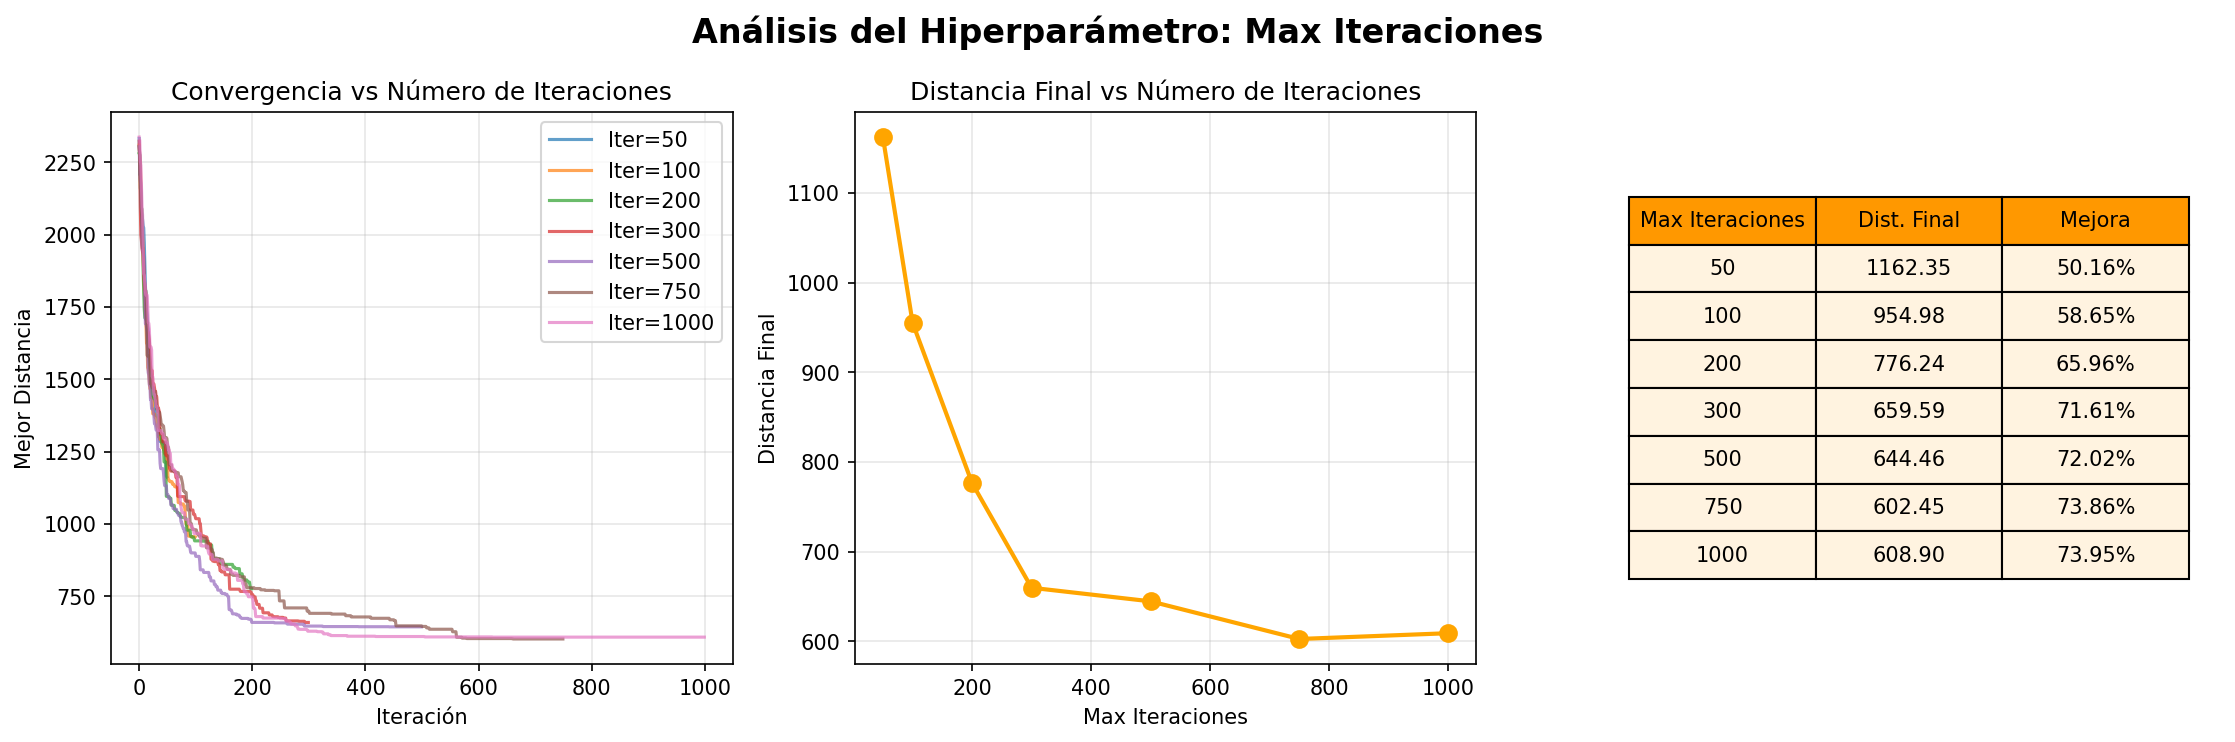

In [196]:
# Visualizar resultados de max_iteraciones
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=150)

# Gráfica 1: Convergencia para cada max_iteraciones
ax1 = axes[0]
for res in resultados_iters:
    ax1.plot(res['historial'], label=f"Iter={res['max_iteraciones']}", alpha=0.7)
ax1.set_xlabel('Iteración')
ax1.set_ylabel('Mejor Distancia')
ax1.set_title('Convergencia vs Número de Iteraciones')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfica 2: Distancia final vs max_iteraciones
ax2 = axes[1]
iter_values = [r['max_iteraciones'] for r in resultados_iters]
dist_finales = [r['distancia_final'] for r in resultados_iters]
ax2.plot(iter_values, dist_finales, 'o-', linewidth=2, markersize=8, color='orange')
ax2.set_xlabel('Max Iteraciones')
ax2.set_ylabel('Distancia Final')
ax2.set_title('Distancia Final vs Número de Iteraciones')
ax2.grid(True, alpha=0.3)

# Gráfica 3: Tabla resumen
ax3 = axes[2]
ax3.axis('tight')
ax3.axis('off')
tabla_data = [[r['max_iteraciones'], f"{r['distancia_final']:.2f}", f"{r['mejora']:.2f}%"] 
              for r in resultados_iters]
tabla = ax3.table(cellText=tabla_data, 
                  colLabels=['Max Iteraciones', 'Dist. Final', 'Mejora'],
                  cellLoc='center', loc='center',
                  colWidths=[0.3, 0.3, 0.3])
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1, 2)
for i in range(len(iter_values) + 1):
    if i == 0:
        tabla[(i, 0)].set_facecolor('#FF9800')
        tabla[(i, 1)].set_facecolor('#FF9800')
        tabla[(i, 2)].set_facecolor('#FF9800')
    else:
        tabla[(i, 0)].set_facecolor('#FFF3E0')
        tabla[(i, 1)].set_facecolor('#FFF3E0')
        tabla[(i, 2)].set_facecolor('#FFF3E0')

plt.suptitle('Análisis del Hiperparámetro: Max Iteraciones', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# SA

In [197]:
MAX_ITERACIONES = 700000

## Compración con Enfriamiento Simulado

En esta sección implementaremos el algoritmo de **Enfriamiento Simulado (Simulated Annealing)** adaptado para el TSP y lo compararemos con HSOA.

### ¿Qué es el Enfriamiento Simulado?
Es una metaheurística inspirada en el proceso físico de enfriamiento de metales. El algoritmo:
- Comienza con una temperatura alta permitiendo movimientos que empeoran la solución
- Gradualmente reduce la temperatura, volviéndose más selectivo
- Acepta soluciones peores con probabilidad decreciente para escapar de óptimos locales

### Implementación del Enfriamiento Simulado para TSP

In [198]:
class EnfriamientoSimulado_TSP:
    
    def __init__(self,
                 matriz_distancias: np.ndarray = MATRIZ_DISTANCIAS,
                 temp_inicial: float = 1000.0,
                 temp_final: float = 0.1,
                 alpha: float = 0.995,
                 max_iteraciones: int = MAX_ITERACIONES,
                 iteraciones_por_temp: int = 100,
                 verbose: bool = True):
        """
        Inicializa el algoritmo de Enfriamiento Simulado para TSP.
        
        Args:
            matriz_distancias: Matriz de distancias entre ciudades
            temp_inicial: Temperatura inicial (alta para aceptar más movimientos)
            temp_final: Temperatura final (baja, casi greedy)
            alpha: Factor de enfriamiento (típicamente entre 0.8 y 0.99)
            max_iteraciones: Número máximo de iteraciones
            iteraciones_por_temp: Número de intentos por cada temperatura
            verbose: Si True, imprime información durante la ejecución
        """
        self.matriz_distancias = matriz_distancias
        self.num_ciudades = len(matriz_distancias)
        self.temp_inicial = temp_inicial
        self.temp_final = temp_final
        self.alpha = alpha
        self.max_iteraciones = max_iteraciones
        self.iteraciones_por_temp = iteraciones_por_temp
        self.verbose = verbose
        
        # Solución actual y mejor
        self.ruta_actual = None
        self.distancia_actual = float('inf')
        self.mejor_ruta = None
        self.mejor_distancia = float('inf')
        
        # Historial
        self.historial_mejor = []
        self.historial_actual = []
        self.historial_temperatura = []
        self.historial_tiempos = []  # Tiempo acumulado por iteración
        self.aceptaciones = []
    
    def probabilidad_aceptacion(self, distancia_nueva: float, distancia_actual: float, 
                               temperatura: float) -> float:
        """
        Calcula la probabilidad de aceptar una solución peor.
        Función de Boltzmann: exp(-ΔE / T)
        """
        if distancia_nueva < distancia_actual:
            return 1.0
        else:
            delta = distancia_nueva - distancia_actual
            return np.exp(-delta / temperatura)
    
    def generar_vecino(self, ruta: List[int]) -> List[int]:
        """
        Genera una solución vecina usando un operador aleatorio.
        Reutiliza los operadores ya definidos en el notebook.
        """
        return aplicar_operador_movimiento(ruta, tipo='aleatorio')
    
    def optimizar(self) -> Tuple[List[int], float]:
        """
        Ejecuta el algoritmo de Enfriamiento Simulado.
        
        Returns:
            Tupla con (mejor_ruta, mejor_distancia)
        """
        tiempo_inicio = time.time()
        
        if self.verbose:
            print("=" * 60)
            print("ENFRIAMIENTO SIMULADO - TSP")
            print("=" * 60)
            print(f"Temperatura inicial: {self.temp_inicial:.2f}")
            print(f"Temperatura final: {self.temp_final:.6f}")
            print(f"Factor de enfriamiento (α): {self.alpha}")
            print(f"Max iteraciones: {self.max_iteraciones}")
            print("=" * 60)
        
        # Inicialización: Generar solución inicial aleatoria
        self.ruta_actual = generar_ruta_aleatoria(self.num_ciudades)
        self.distancia_actual = calcular_distancia_ruta(self.ruta_actual, self.matriz_distancias)
        
        # Establecer como mejor solución inicial
        self.mejor_ruta = self.ruta_actual.copy()
        self.mejor_distancia = self.distancia_actual
        
        if self.verbose:
            print(f"\nSolución inicial: {self.mejor_distancia:.2f}")
        
        # Búsqueda iterativa con enfriamiento
        temperatura = self.temp_inicial
        iteracion = 0
        aceptadas_total = 0
        rechazadas_total = 0
        
        while temperatura > self.temp_final and iteracion < self.max_iteraciones:
            aceptadas_temp = 0
            
            # Intentos a la temperatura actual
            for _ in range(self.iteraciones_por_temp):
                # Generar solución vecina
                ruta_vecina = self.generar_vecino(self.ruta_actual)
                distancia_vecina = calcular_distancia_ruta(ruta_vecina, self.matriz_distancias)
                
                # Calcular probabilidad de aceptación
                prob_aceptacion = self.probabilidad_aceptacion(
                    distancia_vecina, self.distancia_actual, temperatura
                )
                
                # Decidir si aceptar la nueva solución
                if random.random() < prob_aceptacion:
                    self.ruta_actual = ruta_vecina
                    self.distancia_actual = distancia_vecina
                    aceptadas_temp += 1
                    aceptadas_total += 1
                    
                    # Actualizar mejor solución
                    if distancia_vecina < self.mejor_distancia:
                        self.mejor_ruta = ruta_vecina.copy()
                        self.mejor_distancia = distancia_vecina
                else:
                    rechazadas_total += 1
                
                iteracion += 1
                
                # Guardar historial
                self.historial_mejor.append(self.mejor_distancia)
                self.historial_actual.append(self.distancia_actual)
                self.historial_temperatura.append(temperatura)
                self.historial_tiempos.append(time.time() - tiempo_inicio)  # Tiempo acumulado
                
                if iteracion >= self.max_iteraciones:
                    break
            
            # Calcular tasa de aceptación
            tasa_aceptacion = aceptadas_temp / self.iteraciones_por_temp
            self.aceptaciones.append(tasa_aceptacion)
            
            # Mostrar progreso
            if self.verbose and (iteracion % 5000 == 0 or temperatura <= self.temp_final):
                print(f"Iter {iteracion:5d} | Temp: {temperatura:8.4f} | "
                      f"Actual: {self.distancia_actual:8.2f} | "
                      f"Mejor: {self.mejor_distancia:8.2f} | "
                      f"Aceptación: {tasa_aceptacion:.2%}")
            
            # Enfriar
            temperatura *= self.alpha
            
            if iteracion >= self.max_iteraciones:
                break
        
        tiempo_total = time.time() - tiempo_inicio
        
        if self.verbose:
            print("\n" + "=" * 60)
            print("RESULTADO FINAL")
            print("=" * 60)
            print(f"Mejor distancia: {self.mejor_distancia:.2f}")
            print(f"Soluciones aceptadas: {aceptadas_total}")
            print(f"Soluciones rechazadas: {rechazadas_total}")
            print(f"Tasa de aceptación global: {aceptadas_total/(aceptadas_total+rechazadas_total):.2%}")
            print(f"Tiempo de ejecución: {tiempo_total:.2f} segundos")
            print(f"Iteraciones realizadas: {iteracion}")
        
        return self.mejor_ruta, self.mejor_distancia


print("Clase EnfriamientoSimulado_TSP definida correctamente ✓")

Clase EnfriamientoSimulado_TSP definida correctamente ✓


### Ejecución del Enfriamiento Simulado

In [199]:
# Configuración de semilla para reproducibilidad (misma que HSOA)
np.random.seed(42)
random.seed(42)

# Configurar y ejecutar Enfriamiento Simulado
sa = EnfriamientoSimulado_TSP(
    matriz_distancias=MATRIZ_DISTANCIAS,
    temp_inicial=1000.0,              # Temperatura inicial alta
    temp_final=0.1,                   # Temperatura final baja
    alpha=0.995,                      # Factor de enfriamiento
    max_iteraciones=MAX_ITERACIONES,  # Mismo número de iteraciones que HSOA
    iteraciones_por_temp=100,         # Intentos por cada temperatura
    verbose=True
)

mejor_ruta_sa, mejor_distancia_sa = sa.optimizar()

ENFRIAMIENTO SIMULADO - TSP
Temperatura inicial: 1000.00
Temperatura final: 0.100000
Factor de enfriamiento (α): 0.995
Max iteraciones: 700000

Solución inicial: 2800.31
Iter  5000 | Temp: 782.2237 | Actual:  2581.61 | Mejor:  2234.70 | Aceptación: 96.00%
Iter 10000 | Temp: 608.8145 | Actual:  2511.22 | Mejor:  2209.74 | Aceptación: 97.00%
Iter 15000 | Temp: 473.8480 | Actual:  2895.56 | Mejor:  2128.56 | Aceptación: 94.00%
Iter 20000 | Temp: 368.8018 | Actual:  2485.12 | Mejor:  2087.69 | Aceptación: 91.00%
Iter 25000 | Temp: 287.0431 | Actual:  2652.70 | Mejor:  2067.18 | Aceptación: 96.00%
Iter 30000 | Temp: 223.4092 | Actual:  2766.14 | Mejor:  2067.18 | Aceptación: 93.00%
Iter 35000 | Temp: 173.8822 | Actual:  2444.11 | Mejor:  1989.62 | Aceptación: 86.00%
Iter 40000 | Temp: 135.3347 | Actual:  2710.79 | Mejor:  1951.64 | Aceptación: 87.00%
Iter 45000 | Temp: 105.3327 | Actual:  2366.05 | Mejor:  1951.64 | Aceptación: 84.00%
Iter 50000 | Temp:  81.9818 | Actual:  2412.15 | Mejor: 

### Visualización de resultados del Enfriamiento Simulado

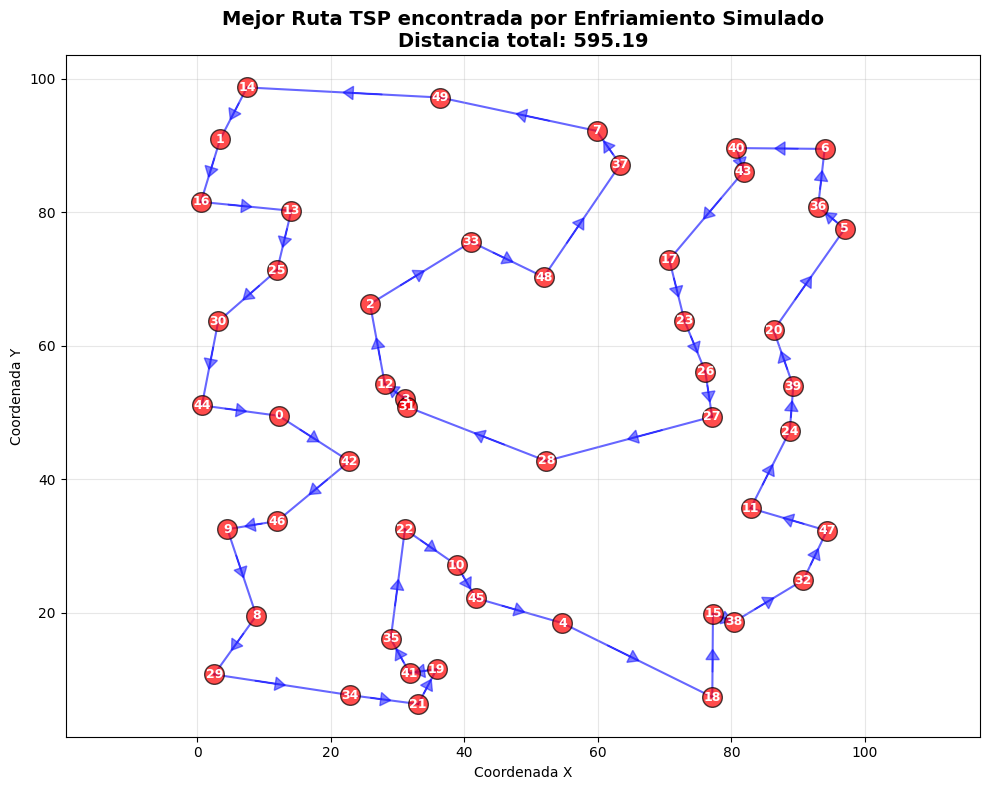

In [200]:
# Visualizar la mejor ruta encontrada por Enfriamiento Simulado
visualizar_ruta(mejor_ruta_sa, COORDENADAS, mejor_distancia_sa, 
                titulo="Mejor Ruta TSP encontrada por Enfriamiento Simulado")

### Gráficas de convergencia del Enfriamiento Simulado

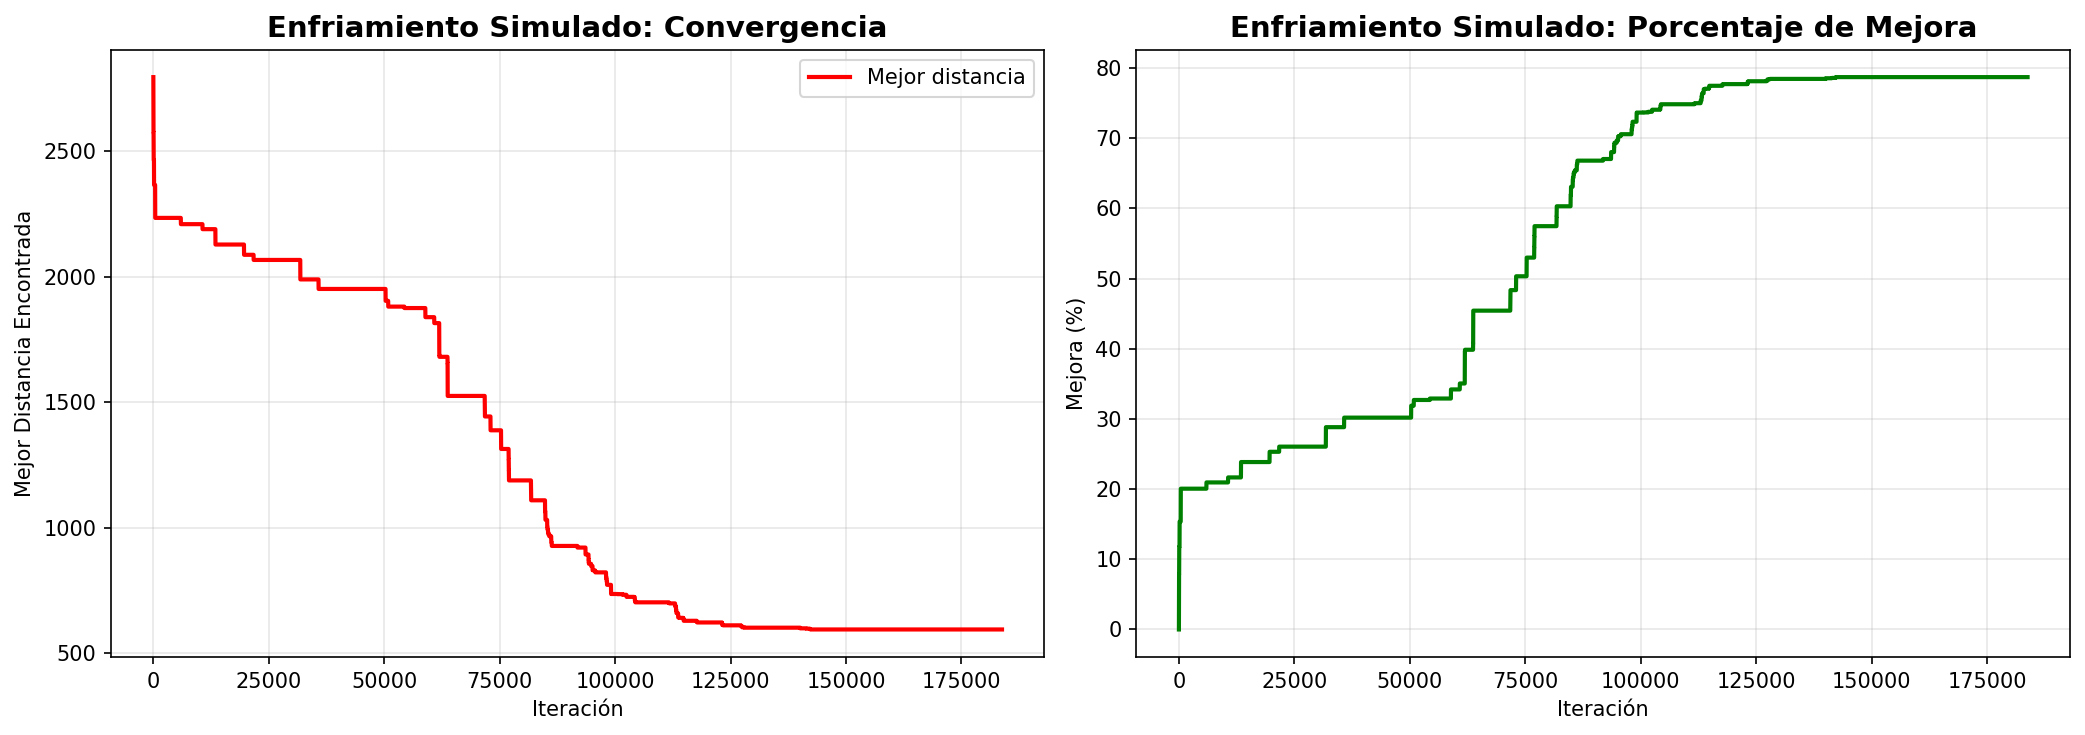

Mejora final SA: 78.71%


In [201]:
# Gráficas de convergencia para SA
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=150)

# Gráfica 1: Mejor distancia vs Iteración
ax1 = axes[0]
ax1.plot(sa.historial_mejor, label='Mejor distancia', linewidth=2, color='red')
ax1.set_xlabel('Iteración')
ax1.set_ylabel('Mejor Distancia Encontrada')
ax1.set_title('Enfriamiento Simulado: Convergencia', fontsize=14, weight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfica 2: Mejora % vs Iteración
ax2 = axes[1]
mejora_sa = ((sa.historial_mejor[0] - np.array(sa.historial_mejor)) / 
             sa.historial_mejor[0] * 100)
ax2.plot(mejora_sa, color='green', linewidth=2)
ax2.set_xlabel('Iteración')
ax2.set_ylabel('Mejora (%)')
ax2.set_title('Enfriamiento Simulado: Porcentaje de Mejora', fontsize=14, weight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mejora final SA: {mejora_sa[-1]:.2f}%")

## Comparación entre HSOA y Enfriamiento Simulado

Ahora compararemos ambos algoritmos de manera visual y cuantitativa.

### Comparación visual de las rutas encontradas

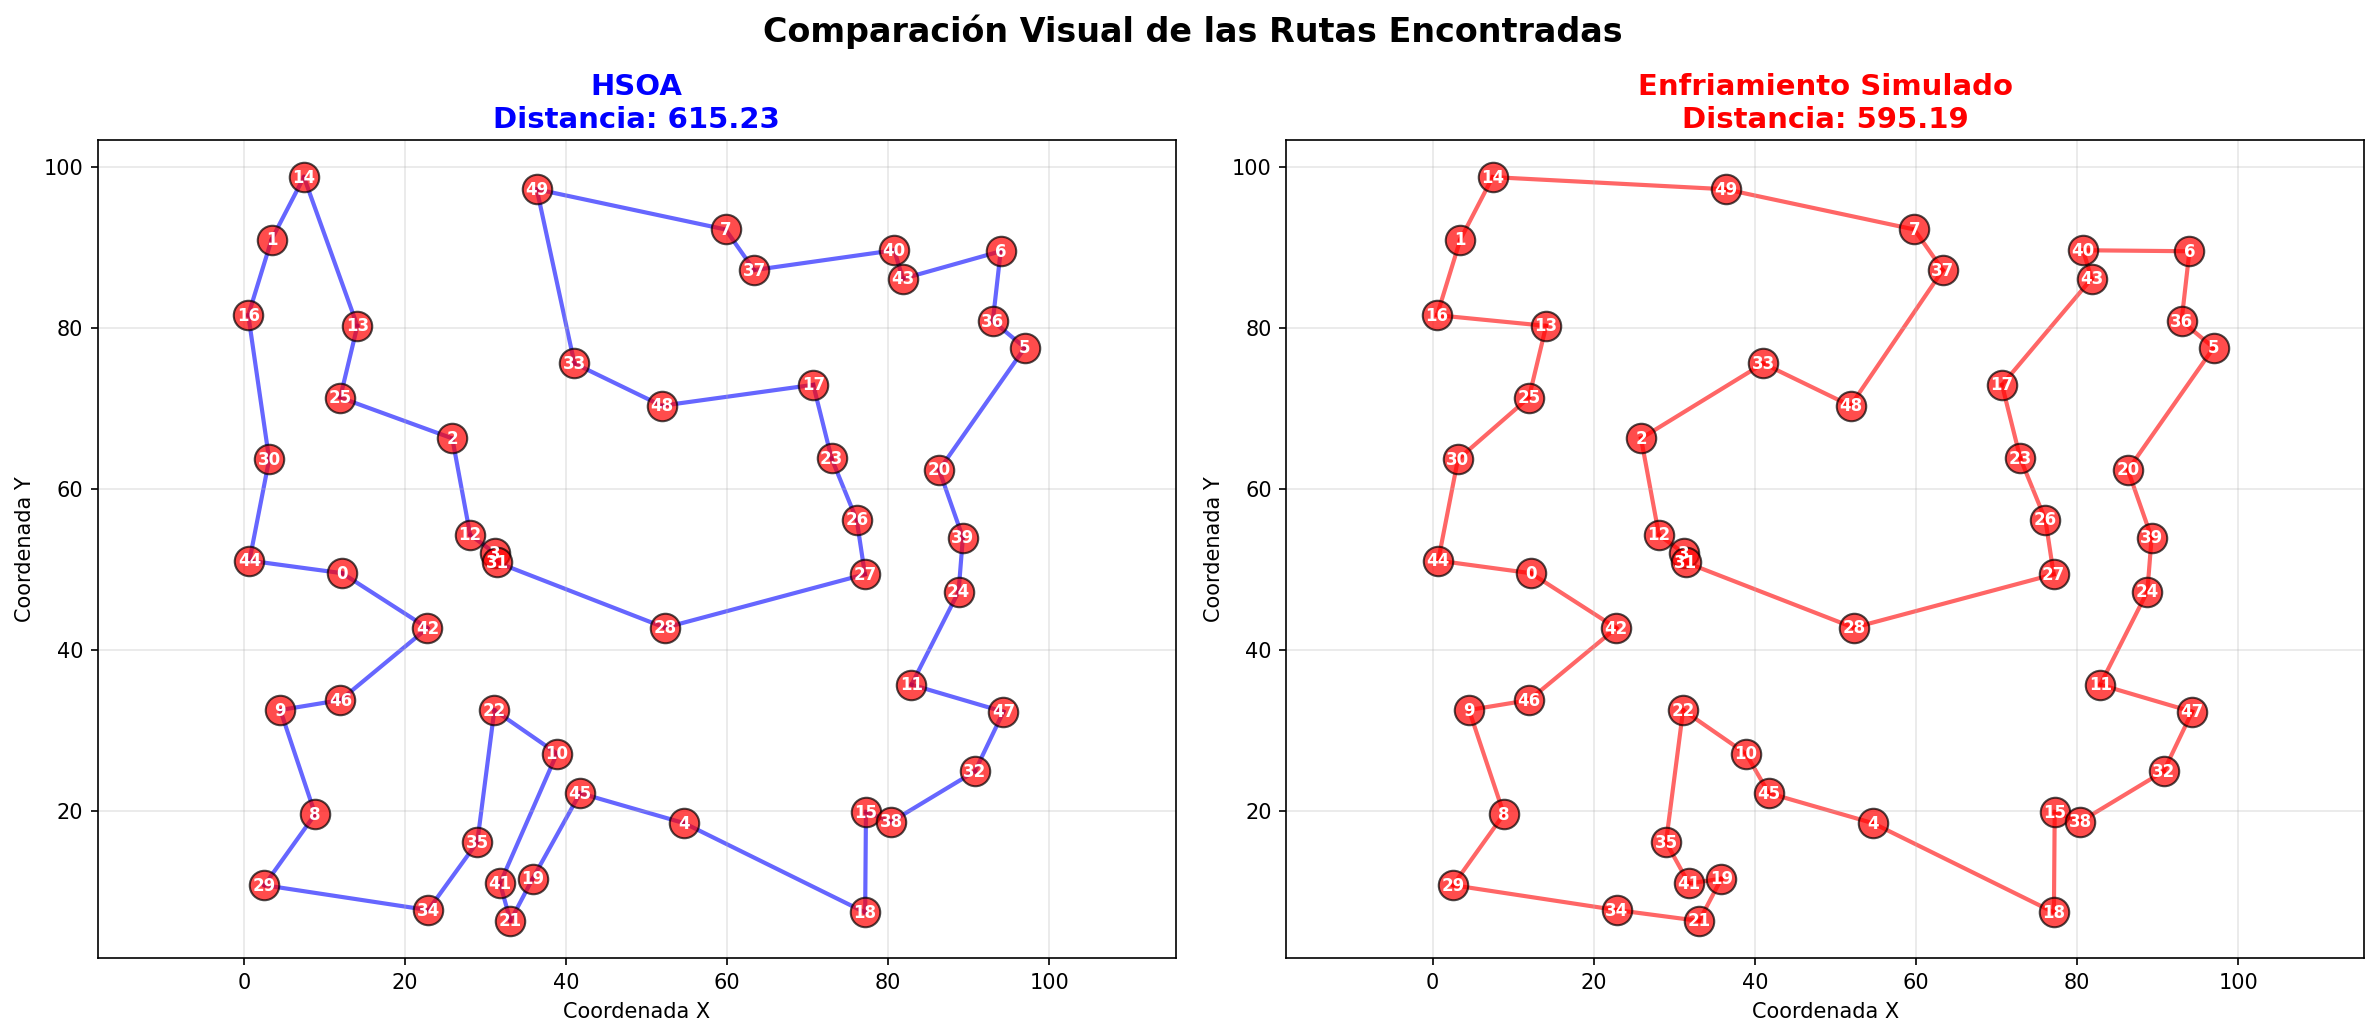

In [202]:
# Visualizar ambas rutas lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 7), dpi=150)

# Ruta HSOA
ax1 = axes[0]
if COORDENADAS is not None:
    # Dibujar las ciudades
    ax1.scatter(COORDENADAS[:, 0], COORDENADAS[:, 1], 
               c='red', s=200, zorder=3, alpha=0.7, edgecolors='black')
    
    # Etiquetar las ciudades
    for i, (x, y) in enumerate(COORDENADAS):
        ax1.annotate(str(i), (x, y), fontsize=8, ha='center', va='center', 
                    color='white', weight='bold')
    
    # Dibujar la ruta HSOA
    for i in range(len(mejor_ruta)):
        ciudad_actual = mejor_ruta[i]
        ciudad_siguiente = mejor_ruta[(i + 1) % len(mejor_ruta)]
        
        x1, y1 = COORDENADAS[ciudad_actual]
        x2, y2 = COORDENADAS[ciudad_siguiente]
        
        ax1.plot([x1, x2], [y1, y2], 'b-', linewidth=2, alpha=0.6, zorder=1)
    
    ax1.set_title(f'HSOA\nDistancia: {mejor_distancia:.2f}', 
                 fontsize=14, weight='bold', color='blue')
    ax1.set_xlabel('Coordenada X')
    ax1.set_ylabel('Coordenada Y')
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')

# Ruta Enfriamiento Simulado
ax2 = axes[1]
if COORDENADAS is not None:
    # Dibujar las ciudades
    ax2.scatter(COORDENADAS[:, 0], COORDENADAS[:, 1], 
               c='red', s=200, zorder=3, alpha=0.7, edgecolors='black')
    
    # Etiquetar las ciudades
    for i, (x, y) in enumerate(COORDENADAS):
        ax2.annotate(str(i), (x, y), fontsize=8, ha='center', va='center', 
                    color='white', weight='bold')
    
    # Dibujar la ruta Enfriamiento Simulado
    for i in range(len(mejor_ruta_sa)):
        ciudad_actual = mejor_ruta_sa[i]
        ciudad_siguiente = mejor_ruta_sa[(i + 1) % len(mejor_ruta_sa)]
        
        x1, y1 = COORDENADAS[ciudad_actual]
        x2, y2 = COORDENADAS[ciudad_siguiente]
        
        ax2.plot([x1, x2], [y1, y2], 'r-', linewidth=2, alpha=0.6, zorder=1)
    
    ax2.set_title(f'Enfriamiento Simulado\nDistancia: {mejor_distancia_sa:.2f}', 
                 fontsize=14, weight='bold', color='red')
    ax2.set_xlabel('Coordenada X')
    ax2.set_ylabel('Coordenada Y')
    ax2.grid(True, alpha=0.3)
    ax2.axis('equal')

plt.suptitle('Comparación Visual de las Rutas Encontradas', 
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Comparación de convergencia: HSOA vs SA (Tiempo de Cómputo)

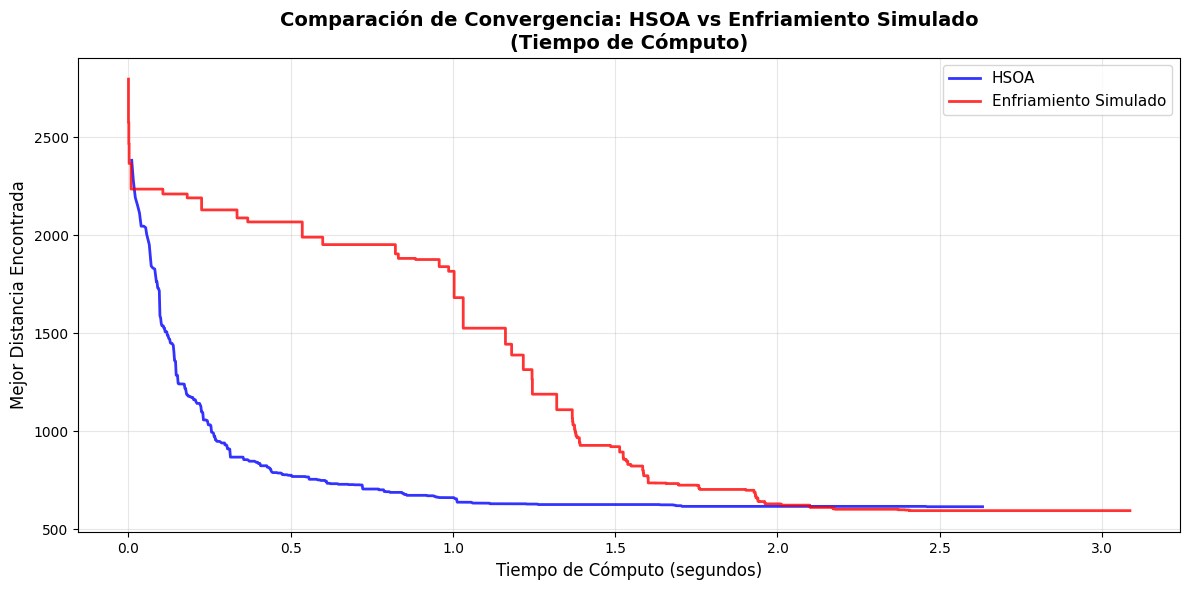

ESTADÍSTICAS COMPARATIVAS

HSOA:
  - Mejor distancia final: 615.23
  - Tiempo total: 2.6321 segundos
  - Mejora: 74.17%
  - Tiempo por iteración: 0.002632 seg

Enfriamiento Simulado:
  - Mejor distancia final: 595.19
  - Tiempo total: 3.0862 segundos
  - Mejora: 78.71%
  - Tiempo por iteración: 0.000017 seg

Comparación:
  - Diferencia en distancia: 20.03 (3.37%)
  - Mejor algoritmo: Enfriamiento Simulado
  - Diferencia de tiempo: 0.4542 segundos


In [203]:
# Comparación de convergencia: HSOA vs SA en función del tiempo de cómputo
plt.figure(figsize=(12, 6))

# Graficar convergencia de HSOA
plt.plot(hsoa.historial_tiempos, hsoa.historial_mejor, 
         label='HSOA', linewidth=2, color='blue', alpha=0.8)

# Graficar convergencia de SA
plt.plot(sa.historial_tiempos, sa.historial_mejor, 
         label='Enfriamiento Simulado', linewidth=2, color='red', alpha=0.8)

plt.xlabel('Tiempo de Cómputo (segundos)', fontsize=12)
plt.ylabel('Mejor Distancia Encontrada', fontsize=12)
plt.title('Comparación de Convergencia: HSOA vs Enfriamiento Simulado\n(Tiempo de Cómputo)', 
          fontsize=14, weight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Estadísticas comparativas
print("=" * 70)
print("ESTADÍSTICAS COMPARATIVAS")
print("=" * 70)
print(f"\nHSOA:")
print(f"  - Mejor distancia final: {hsoa.mejor_distancia:.2f}")
print(f"  - Tiempo total: {hsoa.historial_tiempos[-1]:.4f} segundos")
print(f"  - Mejora: {((hsoa.historial_mejor[0] - hsoa.mejor_distancia) / hsoa.historial_mejor[0] * 100):.2f}%")
print(f"  - Tiempo por iteración: {hsoa.historial_tiempos[-1] / len(hsoa.historial_mejor):.6f} seg")

print(f"\nEnfriamiento Simulado:")
print(f"  - Mejor distancia final: {sa.mejor_distancia:.2f}")
print(f"  - Tiempo total: {sa.historial_tiempos[-1]:.4f} segundos")
print(f"  - Mejora: {((sa.historial_mejor[0] - sa.mejor_distancia) / sa.historial_mejor[0] * 100):.2f}%")
print(f"  - Tiempo por iteración: {sa.historial_tiempos[-1] / len(sa.historial_mejor):.6f} seg")

print(f"\nComparación:")
diferencia_distancia = abs(hsoa.mejor_distancia - sa.mejor_distancia)
porcentaje_diff = (diferencia_distancia / min(hsoa.mejor_distancia, sa.mejor_distancia)) * 100
mejor_algoritmo = "HSOA" if hsoa.mejor_distancia < sa.mejor_distancia else "Enfriamiento Simulado"
print(f"  - Diferencia en distancia: {diferencia_distancia:.2f} ({porcentaje_diff:.2f}%)")
print(f"  - Mejor algoritmo: {mejor_algoritmo}")
print(f"  - Diferencia de tiempo: {abs(hsoa.historial_tiempos[-1] - sa.historial_tiempos[-1]):.4f} segundos")
print("=" * 70)

## Grid Search para Optimización de Hiperparámetros del Enfriamiento Simulado

En esta sección realizaremos un **Grid Search** exhaustivo para encontrar la mejor combinación de hiperparámetros del algoritmo de Enfriamiento Simulado:
- **temp_inicial**: Temperatura inicial
- **temp_final**: Temperatura final
- **alpha**: Factor de enfriamiento (tasa de reducción de temperatura)
- **iteraciones_por_temp**: Número de intentos por cada nivel de temperatura

El Grid Search evaluará todas las combinaciones posibles y seleccionará la configuración óptima.

### Definición del espacio de búsqueda de hiperparámetros

In [205]:
from itertools import product
import pandas as pd

# Definir el espacio de búsqueda para cada hiperparámetro
grid_parametros = {
    'temp_inicial': [500, 1000, 2000, 5000],
    'temp_final': [0.01, 0.1, 1.0],
    'alpha': [0.95, 0.98, 0.99, 0.995],
    'iteraciones_por_temp': [50, 100, 200]
}

# Calcular número total de combinaciones
num_combinaciones = 1
for valores in grid_parametros.values():
    num_combinaciones *= len(valores)

print("=" * 70)
print("GRID SEARCH - ENFRIAMIENTO SIMULADO")
print("=" * 70)
print("\nEspacio de búsqueda definido:")
print(f"  - temp_inicial: {grid_parametros['temp_inicial']}")
print(f"  - temp_final: {grid_parametros['temp_final']}")
print(f"  - alpha: {grid_parametros['alpha']}")
print(f"  - iteraciones_por_temp: {grid_parametros['iteraciones_por_temp']}")
print(f"\nTotal de combinaciones a evaluar: {num_combinaciones}")
print(f"Iteraciones máximas por ejecución: {MAX_ITERACIONES}")
print("=" * 70)

GRID SEARCH - ENFRIAMIENTO SIMULADO

Espacio de búsqueda definido:
  - temp_inicial: [500, 1000, 2000, 5000]
  - temp_final: [0.01, 0.1, 1.0]
  - alpha: [0.95, 0.98, 0.99, 0.995]
  - iteraciones_por_temp: [50, 100, 200]

Total de combinaciones a evaluar: 144
Iteraciones máximas por ejecución: 700000


### Ejecución del Grid Search

Este proceso puede tomar varios minutos dependiendo del número de combinaciones.

In [206]:
# Configurar semilla para reproducibilidad
np.random.seed(42)
random.seed(42)

# Almacenar resultados del grid search
resultados_grid_search = []

# Generar todas las combinaciones de hiperparámetros
combinaciones = list(product(
    grid_parametros['temp_inicial'],
    grid_parametros['temp_final'],
    grid_parametros['alpha'],
    grid_parametros['iteraciones_por_temp']
))

print(f"\nIniciando Grid Search con {len(combinaciones)} combinaciones...")
print("=" * 70)

tiempo_inicio_grid = time.time()

# Evaluar cada combinación
for idx, (temp_ini, temp_fin, alpha_val, iters_temp) in enumerate(combinaciones, 1):
    print(f"\n[{idx}/{len(combinaciones)}] Evaluando configuración:")
    print(f"  temp_inicial={temp_ini}, temp_final={temp_fin}, alpha={alpha_val}, iters_temp={iters_temp}")
    
    # Reiniciar semilla para cada configuración (para comparación justa)
    np.random.seed(42)
    random.seed(42)
    
    tiempo_config_inicio = time.time()
    
    # Crear instancia con configuración actual
    sa_grid = EnfriamientoSimulado_TSP(
        matriz_distancias=MATRIZ_DISTANCIAS,
        temp_inicial=temp_ini,
        temp_final=temp_fin,
        alpha=alpha_val,
        max_iteraciones=MAX_ITERACIONES,
        iteraciones_por_temp=iters_temp,
        verbose=False  # Desactivar salida detallada
    )
    
    # Ejecutar optimización
    mejor_ruta_grid, mejor_distancia_grid = sa_grid.optimizar()
    
    tiempo_config = time.time() - tiempo_config_inicio
    
    # Calcular métricas
    mejora_inicial = sa_grid.historial_mejor[0] - mejor_distancia_grid
    mejora_porcentaje = (mejora_inicial / sa_grid.historial_mejor[0]) * 100
    
    # Guardar resultados
    resultado = {
        'temp_inicial': temp_ini,
        'temp_final': temp_fin,
        'alpha': alpha_val,
        'iteraciones_por_temp': iters_temp,
        'mejor_distancia': mejor_distancia_grid,
        'distancia_inicial': sa_grid.historial_mejor[0],
        'mejora_absoluta': mejora_inicial,
        'mejora_porcentaje': mejora_porcentaje,
        'tiempo_ejecucion': tiempo_config,
        'num_iteraciones_efectivas': len(sa_grid.historial_mejor),
        'historial': sa_grid.historial_mejor.copy(),
        'mejor_ruta': mejor_ruta_grid.copy()
    }
    
    resultados_grid_search.append(resultado)
    
    print(f"  → Distancia final: {mejor_distancia_grid:.2f}")
    print(f"  → Mejora: {mejora_porcentaje:.2f}%")
    print(f"  → Tiempo: {tiempo_config:.2f}s")

tiempo_total_grid = time.time() - tiempo_inicio_grid

print("\n" + "=" * 70)
print("GRID SEARCH COMPLETADO")
print("=" * 70)
print(f"Tiempo total: {tiempo_total_grid:.2f} segundos ({tiempo_total_grid/60:.2f} minutos)")
print(f"Tiempo promedio por configuración: {tiempo_total_grid/len(combinaciones):.2f} segundos")
print("=" * 70)


Iniciando Grid Search con 144 combinaciones...

[1/144] Evaluando configuración:
  temp_inicial=500, temp_final=0.01, alpha=0.95, iters_temp=50
  → Distancia final: 659.33
  → Mejora: 76.41%
  → Tiempo: 0.18s

[2/144] Evaluando configuración:
  temp_inicial=500, temp_final=0.01, alpha=0.95, iters_temp=100
  → Distancia final: 614.34
  → Mejora: 78.02%
  → Tiempo: 0.33s

[3/144] Evaluando configuración:
  temp_inicial=500, temp_final=0.01, alpha=0.95, iters_temp=200
  → Distancia final: 614.34
  → Mejora: 78.02%
  → Tiempo: 0.33s

[3/144] Evaluando configuración:
  temp_inicial=500, temp_final=0.01, alpha=0.95, iters_temp=200
  → Distancia final: 637.54
  → Mejora: 77.19%
  → Tiempo: 0.63s

[4/144] Evaluando configuración:
  temp_inicial=500, temp_final=0.01, alpha=0.98, iters_temp=50
  → Distancia final: 637.54
  → Mejora: 77.19%
  → Tiempo: 0.63s

[4/144] Evaluando configuración:
  temp_inicial=500, temp_final=0.01, alpha=0.98, iters_temp=50
  → Distancia final: 601.96
  → Mejora: 78

### Análisis de resultados del Grid Search

In [207]:
# Crear DataFrame con los resultados
df_resultados = pd.DataFrame(resultados_grid_search)

# Ordenar por mejor distancia
df_resultados_sorted = df_resultados.sort_values('mejor_distancia')

print("=" * 80)
print("TOP 10 MEJORES CONFIGURACIONES")
print("=" * 80)
print(df_resultados_sorted[['temp_inicial', 'temp_final', 'alpha', 'iteraciones_por_temp', 
                             'mejor_distancia', 'mejora_porcentaje', 'tiempo_ejecucion']].head(10).to_string(index=False))

# Identificar la mejor configuración
mejor_config = df_resultados_sorted.iloc[0]

print("\n" + "=" * 80)
print("MEJOR CONFIGURACIÓN ENCONTRADA")
print("=" * 80)
print(f"Hiperparámetros:")
print(f"  - temp_inicial: {mejor_config['temp_inicial']}")
print(f"  - temp_final: {mejor_config['temp_final']}")
print(f"  - alpha: {mejor_config['alpha']}")
print(f"  - iteraciones_por_temp: {mejor_config['iteraciones_por_temp']}")
print(f"\nResultados:")
print(f"  - Mejor distancia: {mejor_config['mejor_distancia']:.2f}")
print(f"  - Distancia inicial: {mejor_config['distancia_inicial']:.2f}")
print(f"  - Mejora absoluta: {mejor_config['mejora_absoluta']:.2f}")
print(f"  - Mejora porcentual: {mejor_config['mejora_porcentaje']:.2f}%")
print(f"  - Tiempo de ejecución: {mejor_config['tiempo_ejecucion']:.2f} segundos")
print(f"  - Iteraciones efectivas: {mejor_config['num_iteraciones_efectivas']}")
print("=" * 80)

# Estadísticas generales
print(f"\nEstadísticas del Grid Search:")
print(f"  - Mejor distancia: {df_resultados['mejor_distancia'].min():.2f}")
print(f"  - Peor distancia: {df_resultados['mejor_distancia'].max():.2f}")
print(f"  - Distancia promedio: {df_resultados['mejor_distancia'].mean():.2f}")
print(f"  - Desviación estándar: {df_resultados['mejor_distancia'].std():.2f}")
print(f"  - Tiempo promedio: {df_resultados['tiempo_ejecucion'].mean():.2f}s")

TOP 10 MEJORES CONFIGURACIONES
 temp_inicial  temp_final  alpha  iteraciones_por_temp  mejor_distancia  mejora_porcentaje  tiempo_ejecucion
         1000        0.01  0.995                   100       595.191205          78.708777          3.920810
         1000        0.10  0.995                   100       595.191205          78.708777          5.009095
         1000        1.00  0.995                   200       596.175283          78.673575          4.583718
         1000        0.01  0.995                   200       596.175283          78.673575          8.574498
         1000        0.10  0.995                   200       596.175283          78.673575          9.462926
          500        0.01  0.990                   100       596.490082          78.662314          1.568757
          500        0.10  0.990                   100       596.490082          78.662314          1.222379
         2000        0.01  0.990                   100       596.490082          78.662314       